In [ ]:
%cd /
from google.colab import drive
drive.mount('/content/gdrive/')

!ln -s /content/gdrive/My\ Drive/ ./mydrive

%cd /content/gdrive/MyDrive/projekt_inzynierski

/
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
ln: failed to create symbolic link './mydrive/My Drive': File exists
/content/gdrive/MyDrive/projekt_inzynierski


In [ ]:
!pip install sentence-transformers -q

In [ ]:
MULTILINGUAL_MODELS = {
    'E5-multilingual-base': 'intfloat/multilingual-e5-base',
    'E5-multilingual-small': 'intfloat/multilingual-e5-small',
    'LaBSE': 'sentence-transformers/LaBSE',
    'MiniLM-multilingual': 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    'MPNet-multilingual': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
}

# Modele anglojęzyczne
ENGLISH_MODELS = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'all-MPNet-base-v2': 'sentence-transformers/all-mpnet-base-v2',
    'paraphrase-MiniLM-L12-v2': 'sentence-transformers/paraphrase-MiniLM-L12-v2',
    'paraphrase-distilroberta-base-v1': 'sentence-transformers/paraphrase-distilroberta-base-v1',
    'stsb-roberta-base': 'sentence-transformers/stsb-roberta-base',
    'all-distilroberta-v1': 'sentence-transformers/all-distilroberta-v1'
}

import pandas as pd
import numpy as np
import time
from typing import List, Dict, Tuple, Optional, Any
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import json
import pickle
from datetime import datetime


RANDOM_STATE = 42
DEFAULT_TOP_K = 10
SILHOUETTE_SAMPLE_SIZE = 1000

# Modele wielojęzyczne do testowania
MULTILINGUAL_MODELS = {
    'E5-multilingual-base': 'intfloat/multilingual-e5-base',
    'E5-multilingual-small': 'intfloat/multilingual-e5-small',
    'LaBSE': 'sentence-transformers/LaBSE',
    'MiniLM-multilingual': 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    'MPNet-multilingual': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
}

# Modele anglojęzyczne
ENGLISH_MODELS = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'all-MPNet-base-v2': 'sentence-transformers/all-mpnet-base-v2',
    'paraphrase-MiniLM-L12-v2': 'sentence-transformers/paraphrase-MiniLM-L12-v2',
    'paraphrase-distilroberta-base-v1': 'sentence-transformers/paraphrase-distilroberta-base-v1',
    'stsb-roberta-base': 'sentence-transformers/stsb-roberta-base',
    'all-distilroberta-v1': 'sentence-transformers/all-distilroberta-v1'
}

SEMANTIC_TEST_GROUPS = {
    'rock_family': ['rock', 'hard rock', 'classic rock', 'alternative rock', 'indie rock', 'punk rock'],
    'electronic': ['electronic', 'techno', 'house', 'trance', 'ambient', 'idm'],
    'metal': ['metal', 'heavy metal', 'death metal', 'black metal', 'thrash metal', 'doom metal'],
    'jazz_soul': ['jazz', 'soul', 'blues', 'funk'],
    'calm_mood': ['chill', 'mellow', 'ambient', 'downtempo', 'lounge'],
    'aggressive': ['aggressive', 'hardcore', 'screamo', 'grindcore'],
    'decades': ['60s', '70s', '80s', '90s', '00s']
}

TAG_CATEGORIES = {
    'rock': ['rock', 'classic rock', 'hard rock', 'alternative rock', 'indie rock',
             'punk rock', 'grunge', 'progressive rock'],
    'electronic': ['electronic', 'house', 'techno', 'trance', 'downtempo', 'idm',
                   'synthpop', 'drum and bass'],
    'classical': ['classical', 'instrumental', 'orchestral', 'soundtrack', 'new age',
                  'piano', 'chamber', 'baroque'],
    'aggressive': ['metal', 'hardcore', 'punk', 'screamo', 'thrash metal',
                   'death metal', 'black metal', 'nu metal']
}

MAIN_GENRES = ['rock', 'pop', 'jazz', 'metal', 'electronic', 'hip hop', 'classical']

In [ ]:
TEST_QUERIES = [
    # Nastrój / emocje
    ('relaksująca muzyka', 'relaxing music', ['chill', 'ambient', 'downtempo', 'chillout', 'mellow']),
    ('smutna muzyka', 'sad music', ['dark ambient', 'emo']),
    ('wesoła muzyka', 'happy music', ['pop', 'dance', 'funk']),
    ('romantyczne piosenki', 'romantic songs', ['love', 'beautiful']),

    # Gatunki
    ('rock progresywny', 'progressive rock', ['progressive rock', 'progressive metal']),
    ('energiczny rock', 'energetic rock', ['rock', 'hard rock', 'punk rock', 'alternative rock']),
    ('metal ekstremalny', 'extreme metal', [
        'death metal', 'black metal', 'doom metal', 'grindcore', 'heavy metal',
        'thrash metal', 'melodic death metal', 'gothic metal', 'power metal',
        'metalcore', 'symphonic metal'
    ]),
    ('muzyka elektroniczna', 'electronic music', [
        'electronic', 'house', 'techno', 'trance', 'idm', 'electro',
        'synthpop', 'trip hop', 'dark ambient', 'ambient', 'dance'
    ]),
    ('hip hop', 'hip hop', ['hip hop', 'rap', 'rnb']),
    ('muzyka klasyczna', 'classical music', ['classical', 'instrumental', 'piano']),
    ('jazz i soul', 'jazz and soul', ['jazz', 'soul', 'blues', 'funk', 'rnb']),
    ('rock alternatywny', 'alternative rock', [
        'alternative', 'post rock', 'post punk', 'indie', 'psychedelic', 'grunge'
    ]),
    ('pop', 'pop', ['pop', 'indie pop', 'j pop', 'pop rock', 'britpop']),
    ('muzyka folkowa / akustyczna', 'folk / acoustic music', ['folk', 'acoustic']),

    # Instrumenty / wokal
    ('muzyka fortepianowa', 'piano music', ['piano', 'instrumental', 'classical']),
    ('muzyka gitarowa', 'guitar music', ['guitar', 'acoustic', 'rock', 'blues rock']),
    ('śpiew żeński', 'female vocals', ['female vocalists']),
    ('śpiew męski', 'male vocals', ['male vocalists']),

    # Dekady
    ('muzyka lat 60.', '60s music', ['60s', 'rock', 'classic rock', 'folk']),
    ('muzyka lat 70.', '70s music', ['70s', 'classic rock', 'rock']),
    ('muzyka lat 80.', '80s music', ['80s', 'new wave', 'synthpop', 'pop']),
    ('muzyka lat 90.', '90s music', ['90s', 'grunge', 'alternative', 'rock']),
    ('muzyka XXI wieku', '21st century music', ['00s', 'pop', 'electronic', 'indie', 'rap']),

    # Styl / atmosfera
    ('muzyka taneczna', 'dance music', ['dance', 'house', 'electronic', 'trance']),
    ('muzyka chilloutowa', 'chillout music', ['chill', 'chillout', 'downtempo', 'lounge', 'ambient']),
    ('muzyka psychodeliczna', 'psychedelic music', ['psychedelic', 'psychedelic rock', 'progressive rock']),
    ('muzyka folkowa', 'folk music', ['folk', 'acoustic', 'singer songwriter']),

    # Pochodzenie
    ('muzyka japońska', 'japanese music', ['j pop', 'japanese']),
    ('muzyka brytyjska', 'british music', ['british', 'britpop']),
    ('muzyka francuska', 'french music', ['french']),
    ('muzyka szwedzka', 'swedish music', ['swedish']),
    ('muzyka amerykańska', 'american music', ['american']),
    ('muzyka niemiecka', 'german music', ['german']),
    ('muzyka polska', 'polish music', ['polish']),
    ('muzyka rosyjska', 'russian music', ['russian']),
]


CATEGORIZED_TEST_QUERIES = {
    'mood_emotion': {
        'name': 'Nastrój i emocje',
        'queries': [
            ('relaksująca muzyka', 'relaxing music', ['chill', 'ambient', 'downtempo', 'chillout', 'mellow']),
            ('smutna muzyka', 'sad music', ['dark ambient', 'emo']),
            ('wesoła muzyka', 'happy music', ['pop', 'dance', 'funk']),
            ('romantyczne piosenki', 'romantic songs', ['love', 'beautiful']),
            ('mroczna i niepokojąca', 'dark and unsettling', ['dark ambient', 'gothic', 'doom metal', 'industrial', 'noise']),
            ('nostalgiczna i melancholijna', 'nostalgic and melancholic', ['indie', 'acoustic', 'singer songwriter', 'folk', 'emo']),
            ('agresywna i brutalna', 'aggressive and brutal', ['death metal', 'grindcore', 'hardcore', 'metalcore', 'thrash metal']),
            ('eteryczna i przestrzenna', 'ethereal and spacey', ['ambient', 'post rock', 'psychedelic', 'new age', 'downtempo']),
        ]
    },
    'genres_specific': {
        'name': 'Konkretne gatunki',
        'queries': [
            ('rock progresywny', 'progressive rock', ['progressive rock', 'progressive metal']),
            ('energiczny rock', 'energetic rock', ['rock', 'hard rock', 'punk rock', 'alternative rock']),
            ('metal ekstremalny', 'extreme metal', [
                'death metal', 'black metal', 'doom metal', 'grindcore', 'heavy metal',
                'thrash metal', 'melodic death metal', 'gothic metal', 'power metal',
                'metalcore', 'symphonic metal'
            ]),
            ('muzyka elektroniczna', 'electronic music', [
                'electronic', 'house', 'techno', 'trance', 'idm', 'electro',
                'synthpop', 'trip hop', 'dark ambient', 'ambient', 'dance'
            ]),
            ('hip hop', 'hip hop', ['hip hop', 'rap', 'rnb']),
            ('muzyka klasyczna', 'classical music', ['classical', 'instrumental', 'piano']),
            ('jazz i soul', 'jazz and soul', ['jazz', 'soul', 'blues', 'funk', 'rnb']),
            ('rock alternatywny', 'alternative rock', [
                'alternative', 'post rock', 'post punk', 'indie', 'psychedelic', 'grunge'
            ]),
            ('pop', 'pop', ['pop', 'indie pop', 'j pop', 'pop rock', 'britpop']),
            ('muzyka folkowa / akustyczna', 'folk / acoustic music', ['folk', 'acoustic']),
        ]
    },
    'complex_combinations': {
        'name': 'Złożone kombinacje',
        'queries': [
            ('smutny rock z lat 90', 'sad 90s rock', ['90s', 'grunge', 'alternative', 'emo', 'post punk']),
            ('elektronika do tańca z wokalem', 'electronic dance with vocals', ['house', 'trance', 'synthpop', 'dance', 'electro']),
            ('ciężka muzyka z melodyjnym wokalem', 'heavy music with melodic vocals', ['melodic death metal', 'gothic metal', 'symphonic metal', 'power metal']),
            ('spokojna muzyka instrumentalna', 'calm instrumental music', ['ambient', 'classical', 'piano', 'new age', 'instrumental']),
            ('energetyczna muzyka bez gitar', 'energetic music without guitars', ['electronic', 'house', 'techno', 'hip hop', 'drum and bass']),
            ('stara muzyka taneczna', 'old dance music', ['disco', 'funk', '70s', '80s', 'soul']),
            ('współczesny jazz eksperymentalny', 'modern experimental jazz', ['jazz', 'experimental', 'avant garde', 'noise']),
            ('muzyka do pracy przy komputerze', 'music for computer work', ['ambient', 'chillout', 'downtempo', 'lounge', 'instrumental']),
        ]
    },
    'metaphorical_descriptive': {
        'name': 'Metaforyczne i opisowe',
        'queries': [
            ('muzyka jak podróż kosmiczna', 'music like space journey', ['psychedelic', 'ambient', 'post rock', 'progressive rock', 'electronic']),
            ('brzmienie wielkiego miasta', 'big city sound', ['hip hop', 'electronic', 'industrial', 'jazz', 'trip hop']),
            ('muzyka z klimatem nordyckim', 'music with nordic atmosphere', ['black metal', 'dark ambient', 'folk', 'swedish']),
            ('dźwięki pustyni', 'desert sounds', ['psychedelic rock', 'blues rock', 'folk', 'world']),
            ('muzyka do samotnych wędrówek', 'music for solitary wandering', ['ambient', 'post rock', 'folk', 'acoustic', 'instrumental']),
            ('brzmienie postapokaliptyczne', 'post-apocalyptic sound', ['industrial', 'dark ambient', 'doom metal', 'noise']),
            ('muzyka jak z filmu noir', 'film noir music', ['jazz', 'blues', 'dark ambient', 'trip hop']),
            ('dźwięki undergroundowe', 'underground sounds', ['punk', 'hardcore', 'grindcore', 'noise', 'experimental']),
        ]
    },
    'cultural_context': {
        'name': 'Kontekst kulturowy',
        'queries': [
            ('muzyka z brytyjskiej sceny niezależnej', 'british indie scene music', ['britpop', 'indie', 'british', 'alternative', 'post punk']),
            ('skandynawski metal', 'scandinavian metal', ['black metal', 'death metal', 'swedish', 'melodic death metal']),
            ('muzyka z japońskich gier', 'japanese game music', ['japanese', 'j pop', 'soundtrack', 'instrumental', 'electronic']),
            ('amerykański rock południowy', 'american southern rock', ['blues rock', 'country', 'american', 'classic rock']),
            ('berlińska elektronika', 'berlin electronic', ['techno', 'electronic', 'industrial', 'german', 'minimal']),
            ('muzyka latynoska', 'latin music', ['reggae', 'ska', 'funk', 'world']),
            ('dźwięki wschodnioeuropejskie', 'eastern european sounds', ['polish', 'russian', 'folk', 'classical']),
            ('francuska muzyka artystyczna', 'french art music', ['french', 'avant garde', 'experimental', 'classical']),
        ]
    },
    'activity_situation': {
        'name': 'Aktywność i sytuacja',
        'queries': [
            ('muzyka do biegania', 'running music', ['dance', 'electronic', 'punk rock', 'drum and bass', 'hardcore']),
            ('muzyka na imprezę', 'party music', ['dance', 'house', 'hip hop', 'pop', 'funk']),
            ('muzyka do nauki', 'study music', ['classical', 'ambient', 'instrumental', 'piano', 'lounge']),
            ('muzyka do medytacji', 'meditation music', ['ambient', 'new age', 'chillout', 'instrumental']),
            ('muzyka na road trip', 'road trip music', ['rock', 'classic rock', 'indie', 'alternative', 'country']),
            ('muzyka do gotowania', 'cooking music', ['jazz', 'soul', 'funk', 'lounge', 'bossa nova']),
            ('muzyka przed snem', 'bedtime music', ['ambient', 'classical', 'acoustic', 'mellow', 'new age']),
            ('muzyka motywacyjna', 'motivational music', ['power metal', 'hardcore', 'hip hop', 'punk rock']),
        ]
    },
    'negative_queries': {
        'name': 'Zapytania negatywne (czego NIE)',
        'queries': [
            ('muzyka bez elektroniki', 'music without electronics', ['acoustic', 'classical', 'folk', 'blues', 'jazz']),
            ('rock ale nie metal', 'rock but not metal', ['indie rock', 'alternative rock', 'classic rock', 'punk rock', 'post rock']),
            ('spokojne ale nie klasyczne', 'calm but not classical', ['ambient', 'chillout', 'folk', 'acoustic', 'new age']),
            ('taneczne ale nie pop', 'danceable but not pop', ['house', 'techno', 'drum and bass', 'funk', 'disco']),
            ('gitarowe ale nie rockowe', 'guitar but not rock', ['folk', 'acoustic', 'blues', 'classical', 'jazz']),
            ('stare ale nie rock', 'old but not rock', ['classical', 'jazz', 'blues', 'folk', 'soul']),
            ('ciężkie ale nie screamo', 'heavy but not screamo', ['doom metal', 'death metal', 'sludge', 'industrial']),
            ('wokal ale nie po angielsku', 'vocals but not english', ['french', 'german', 'polish', 'russian', 'japanese']),
        ]
    },
    'subgenres_specific': {
        'name': 'Specyficzne podgatunki',
        'queries': [
            ('shoegaze i dream pop', 'shoegaze and dream pop', ['indie', 'alternative', 'psychedelic', 'post rock', 'ambient']),
            ('math rock', 'math rock', ['progressive rock', 'post rock', 'experimental', 'instrumental', 'indie']),
            ('vaporwave', 'vaporwave', ['electronic', 'experimental', 'ambient', 'chillout']),
            ('post-metal', 'post-metal', ['post rock', 'doom metal', 'progressive metal', 'instrumental']),
            ('dark wave', 'dark wave', ['gothic', 'new wave', 'synthpop', 'post punk', 'dark ambient']),
            ('breakcore', 'breakcore', ['drum and bass', 'electronic', 'experimental', 'hardcore', 'noise']),
            ('dungeon synth', 'dungeon synth', ['dark ambient', 'black metal', 'instrumental', 'ambient']),
            ('slowcore', 'slowcore', ['indie', 'alternative', 'mellow', 'acoustic', 'emo']),
        ]
    },
    'instruments_vocals': {
        'name': 'Instrumenty i wokale',
        'queries': [
            ('muzyka fortepianowa', 'piano music', ['piano', 'instrumental', 'classical']),
            ('muzyka gitarowa', 'guitar music', ['guitar', 'acoustic', 'rock', 'blues rock']),
            ('śpiew żeński', 'female vocals', ['female vocalists']),
            ('śpiew męski', 'male vocals', ['male vocalists']),
            ('muzyka orkiestrowa', 'orchestral music', ['classical', 'symphonic metal', 'soundtrack', 'instrumental']),
            ('muzyka z syntezatorami', 'synthesizer music', ['synthpop', 'electronic', 'new wave', '80s', 'electro']),
            ('muzyka perkusyjna', 'percussion music', ['drum and bass', 'tribal', 'experimental', 'jazz']),
        ]
    },
    'decades': {
        'name': 'Dekady',
        'queries': [
            ('muzyka lat 60.', '60s music', ['60s', 'rock', 'classic rock', 'folk']),
            ('muzyka lat 70.', '70s music', ['70s', 'classic rock', 'rock']),
            ('muzyka lat 80.', '80s music', ['80s', 'new wave', 'synthpop', 'pop']),
            ('muzyka lat 90.', '90s music', ['90s', 'grunge', 'alternative', 'rock']),
            ('muzyka XXI wieku', '21st century music', ['00s', 'pop', 'electronic', 'indie', 'rap']),
            ('muzyka sprzed 1960', 'pre-1960 music', ['classical', 'jazz', 'blues', 'oldies', 'folk']),
            ('muzyka z przełomu wieków', 'turn of millennium music', ['90s', '00s', 'nu metal', 'alternative']),
            ('współczesna muzyka', 'contemporary music', ['00s', 'indie', 'electronic', 'experimental']),
        ]
    },
    'style_atmosphere': {
        'name': 'Styl i atmosfera',
        'queries': [
            ('muzyka taneczna', 'dance music', ['dance', 'house', 'electronic', 'trance']),
            ('muzyka chilloutowa', 'chillout music', ['chill', 'chillout', 'downtempo', 'lounge', 'ambient']),
            ('muzyka psychodeliczna', 'psychedelic music', ['psychedelic', 'psychedelic rock', 'progressive rock']),
            ('muzyka folkowa', 'folk music', ['folk', 'acoustic', 'singer songwriter']),
            ('muzyka minimalistyczna', 'minimalist music', ['ambient', 'minimal', 'experimental', 'drone']),
            ('muzyka epicka', 'epic music', ['power metal', 'symphonic metal', 'soundtrack', 'progressive rock']),
            ('muzyka intymna', 'intimate music', ['acoustic', 'singer songwriter', 'folk', 'indie']),
            ('muzyka eksperymentalna', 'experimental music', ['experimental', 'avant garde', 'noise', 'idm']),
        ]
    },
    'geographical': {
        'name': 'Pochodzenie geograficzne',
        'queries': [
            ('muzyka japońska', 'japanese music', ['j pop', 'japanese']),
            ('muzyka brytyjska', 'british music', ['british', 'britpop']),
            ('muzyka francuska', 'french music', ['french']),
            ('muzyka szwedzka', 'swedish music', ['swedish']),
            ('muzyka amerykańska', 'american music', ['american']),
            ('muzyka niemiecka', 'german music', ['german']),
            ('muzyka polska', 'polish music', ['polish']),
            ('muzyka rosyjska', 'russian music', ['russian']),
        ]
    }
}

## Funckje pomocnicze

In [ ]:
def is_e5_model(model_name: str) -> bool:
    """Sprawdza, czy model należy do rodziny E5."""
    return 'e5' in model_name.lower()


def encode_text(model: SentenceTransformer, text: str, model_name: str,
                is_query: bool = False) -> np.ndarray:
    """
    Enkoduje tekst z uwzględnieniem specjalnych prefiksów dla modeli E5.

    Args:
        model: Model SentenceTransformer
        text: Tekst do zakodowania
        model_name: Nazwa modelu
        is_query: Czy tekst jest zapytaniem (dla E5)

    Returns:
        Embedding tekstu
    """
    if is_e5_model(model_name):
        prefix = "query: " if is_query else "passage: "
        return model.encode(f"{prefix}{text}")
    return model.encode(text)


def encode_texts_batch(model: SentenceTransformer, texts: List[str],
                       model_name: str, is_query: bool = False,
                       show_progress: bool = True) -> np.ndarray:
    """
    Enkoduje listę tekstów batchowo.

    Args:
        model: Model SentenceTransformer
        texts: Lista tekstów do zakodowania
        model_name: Nazwa modelu
        is_query: Czy teksty są zapytaniami (dla E5)
        show_progress: Czy pokazywać pasek postępu

    Returns:
        Macierz embeddingów
    """
    if is_e5_model(model_name):
        prefix = "query: " if is_query else "passage: "
        texts = [f"{prefix}{text}" for text in texts]
    return model.encode(texts, show_progress_bar=show_progress)


def create_tag_embeddings(tags: List[str], model: SentenceTransformer,
                          model_name: str) -> Dict[str, np.ndarray]:
    """
    Tworzy embeddingi dla wszystkich unikalnych tagów.

    Args:
        tags: Lista tagów
        model: Model SentenceTransformer
        model_name: Nazwa modelu

    Returns:
        Słownik {tag: embedding}
    """
    embeddings = encode_texts_batch(model, tags, model_name, is_query=False)
    return dict(zip(tags, embeddings))


def calculate_pairwise_similarity(embeddings: np.ndarray) -> np.ndarray:
    """
    Oblicza podobieństwa między wszystkimi parami embeddingów.
    Zwraca tylko górną trójkątną część macierzy (bez diagonali).
    """
    sim_matrix = cosine_similarity(embeddings)
    triu_indices = np.triu_indices(len(embeddings), k=1)
    return sim_matrix[triu_indices]


def get_top_similar_tags(query_embedding: np.ndarray,
                         tag_embeddings: Dict[str, np.ndarray],
                         top_k: int = DEFAULT_TOP_K) -> List[Tuple[str, float]]:
    """
    Znajduje najbardziej podobne tagi do danego zapytania.

    Args:
        query_embedding: Embedding zapytania
        tag_embeddings: Słownik embeddingów tagów
        top_k: Liczba tagów do zwrócenia

    Returns:
        Lista krotek (tag, podobieństwo) posortowana malejąco
    """
    similarities = [
        (tag, cosine_similarity([query_embedding], [emb])[0][0])
        for tag, emb in tag_embeddings.items()
    ]
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]


def filter_existing_tags(tags: List[str], available_tags: List[str]) -> List[str]:
    """Filtruje tagi do tych dostępnych w zbiorze."""
    return [t for t in tags if t in available_tags]


def get_tag_category(tag: str, categories: Dict[str, List[str]]) -> str:
    """Przypisuje tag do kategorii na podstawie słownika."""
    for category, tag_list in categories.items():
        if tag in tag_list:
            return category
    return 'other'

## Funkcje przetwarzania danych

In [ ]:
def load_and_prepare_data(filepath: str) -> Tuple[pd.DataFrame, List[str]]:
    """
    Wczytuje dane i przygotowuje listę unikalnych tagów.

    Args:
        filepath: Ścieżka do pliku CSV

    Returns:
        Tuple (DataFrame, lista przetworzonych tagów)
    """
    df = pd.read_csv(filepath)

    df['tags'] = df['tags'].fillna("")
    df['genre'] = df['genre'].fillna("")

    df['tags_list'] = df['tags'].apply(
        lambda x: [tag.strip().lower() for tag in x.split(',')]
    )

    all_tags = [tag for tags in df['tags_list'] for tag in tags]
    unique_tags = list(set(all_tags))
    unique_tags = [tag for tag in unique_tags if tag]
    processed_tags = [tag.replace('_', ' ') for tag in unique_tags]

    return df, processed_tags


def print_tag_statistics(df: pd.DataFrame) -> None:
    """Wyświetla statystyki rozkładu tagów."""
    tag_counts = df['tags_count'].tolist()

    print("Tag distribution:")
    print(f"  Mean tags per track: {np.mean(tag_counts):.2f}")
    print(f"  Median: {np.median(tag_counts):.0f}")
    print(f"  Min/Max: {min(tag_counts)}/{max(tag_counts)}")


def plot_tag_distribution(df: pd.DataFrame) -> None:
    """Tworzy histogram rozkładu tagów."""
    tag_counts = df['tags_count'].tolist()

    plt.figure(figsize=(8, 4))
    plt.hist(tag_counts, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of tags')
    plt.ylabel('Number of tracks')
    plt.title('Tags per track distribution')
    plt.axvline(np.mean(tag_counts), color='red', linestyle='--',
                label=f'Mean: {np.mean(tag_counts):.1f}')
    plt.legend()
    plt.show()

## Funkcje wizualizacji

In [ ]:
def visualize_tag_similarities(query: str, model: SentenceTransformer,
                                model_name: str,
                                tag_embeddings: Dict[str, np.ndarray],
                                top_k: int = 15) -> None:
    """
    Wizualizuje podobieństwo zapytania do tagów.

    Args:
        query: Zapytanie tekstowe
        model: Model SentenceTransformer
        model_name: Nazwa modelu
        tag_embeddings: Słownik embeddingów tagów
        top_k: Liczba tagów do wyświetlenia
    """
    query_embedding = encode_text(model, query, model_name, is_query=True)
    top_tags = get_top_similar_tags(query_embedding, tag_embeddings, top_k)

    plt.figure(figsize=(10, 6))
    tags, sims = zip(*top_tags)
    plt.barh(range(len(tags)), sims)
    plt.yticks(range(len(tags)), tags)
    plt.xlabel('Similarity')
    plt.title(f'Tag similarities for: "{query}"')
    plt.xlim(0, 1)

    for i, (tag, sim) in enumerate(top_tags):
        plt.text(sim, i, f' {sim:.3f}', va='center')

    plt.tight_layout()
    plt.show()


def create_interactive_visualization(tag_embeddings: Dict[str, np.ndarray],
                                     model_name: str) -> None:
    """
    Tworzy interaktywną wizualizację t-SNE embeddingów tagów.

    Args:
        tag_embeddings: Słownik embeddingów tagów
        model_name: Nazwa modelu (do tytułu)
    """
    tags = list(tag_embeddings.keys())
    embeddings = np.array(list(tag_embeddings.values()))

    print("Running t-SNE for interactive plot...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE)
    embeddings_2d = tsne.fit_transform(embeddings)

    categories = [get_tag_category(tag, TAG_CATEGORIES) for tag in tags]

    viz_df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'tag': tags,
        'category': categories
    })

    fig = px.scatter(
        viz_df, x='x', y='y',
        color='category',
        hover_data=['tag'],
        title=f'Interactive Tag Embeddings Visualization - {model_name}',
        width=1000, height=700
    )

    fig.update_traces(marker=dict(size=8))
    fig.update_layout(hoverlabel=dict(bgcolor="white", font_size=12))
    fig.show()

# Testy podstawowe

**Test 1 – Semantic Similarity**

Ten test sprawdza, czy model poprawnie odwzorowuje znaczeniowe relacje między tagami muzycznymi.
Jeśli tagi o podobnym znaczeniu (np. rock, hard rock, classic rock) znajdują się blisko siebie w przestrzeni wektorowej, oznacza to, że model dobrze rozumie ich sens.

Dla kilku grup logicznie powiązanych tagów obliczana jest średnia wartość podobieństwa kosinusowego między ich embeddingami.
Wysoki wynik oznacza, że model tworzy spójną przestrzeń semantyczną.

In [ ]:
def test_semantic_similarity(model: SentenceTransformer, model_name: str,
                             processed_tags: List[str]) -> Tuple[float, Dict[str, float]]:
    """
    Test 1 - Sprawdza czy model grupuje podobne tagi blisko siebie.

    Dla kilku grup logicznie powiązanych tagów obliczana jest średnia wartość
    podobieństwa kosinusowego między ich embeddingami.

    Args:
        model: Model SentenceTransformer
        model_name: Nazwa modelu
        processed_tags: Lista dostępnych tagów

    Returns:
        Tuple (średni wynik, słownik wyników per grupa)
    """
    print("\nTesting Semantic Similarity...")

    group_scores = {}

    for group_name, tags in SEMANTIC_TEST_GROUPS.items():
        existing_tags = filter_existing_tags(tags, processed_tags)

        if len(existing_tags) < 2:
            continue

        embeddings = encode_texts_batch(model, existing_tags, model_name,
                                        show_progress=False)
        similarities = calculate_pairwise_similarity(embeddings)
        avg_sim = np.mean(similarities)

        group_scores[group_name] = avg_sim
        print(f"  {group_name:15s}: {avg_sim:.3f} ({len(existing_tags)} tags)")

    overall_score = np.mean(list(group_scores.values()))
    print(f"\nOverall semantic similarity: {overall_score:.3f}")

    return overall_score, group_scores

**Test 2 – Clustering Quality**

Ocenia, jak dobrze model grupuje podobne tagi w przestrzeni wektorowej.
Każdy tag jest zamieniany na embedding, a następnie wykonywane jest grupowanie metodą K-Means dla różnych liczb klastrów.

Jako miarę jakości używany jest silhouette score, który pokazuje, jak wyraźnie odseparowane są klastry — im wyższy wynik, tym lepiej model oddziela różne grupy znaczeniowe.

Dodatkowo test sprawdza, czy główne gatunki muzyczne (np. rock, pop, jazz, metal) trafiają do osobnych klastrów.
Dobry wynik oznacza, że model potrafi naturalnie organizować przestrzeń semantyczną tak, by podobne tagi znajdowały się blisko siebie, a różne – w odrębnych grupach.

In [ ]:
def test_clustering_quality(model: SentenceTransformer, model_name: str,
                            processed_tags: List[str]) -> Tuple[float, float]:
    """
    Test 2 - Sprawdza jak dobrze model klasteryzuje tagi.

    Ocenia jakość grupowania metodą K-Means dla różnych liczb klastrów
    używając silhouette score.

    Args:
        model: Model SentenceTransformer
        model_name: Nazwa modelu
        processed_tags: Lista dostępnych tagów

    Returns:
        Tuple (średni silhouette score, separation score dla głównych gatunków)
    """
    print("\nTesting Clustering Quality...")

    embeddings = encode_texts_batch(model, processed_tags, model_name,
                                    show_progress=False)

    cluster_scores = {}
    for n_clusters in [5, 8, 10, 12]:
        kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
        clusters = kmeans.fit_predict(embeddings)

        sil_score = silhouette_score(
            embeddings, clusters, metric='cosine',
            sample_size=min(SILHOUETTE_SAMPLE_SIZE, len(embeddings))
        )
        cluster_scores[n_clusters] = sil_score
        print(f"  {n_clusters:2d} clusters: {sil_score:.3f}")

    # Sprawdzenie separacji głównych gatunków
    kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(embeddings)

    genre_clusters = {}
    for genre in MAIN_GENRES:
        if genre in processed_tags:
            idx = processed_tags.index(genre)
            genre_clusters[genre] = clusters[idx]

    unique_clusters = len(set(genre_clusters.values()))
    separation_score = unique_clusters / len(genre_clusters) if genre_clusters else 0

    print(f"\n  Main genres separation: {separation_score:.2%} in different clusters")

    avg_silhouette = np.mean(list(cluster_scores.values()))
    print(f"  Average silhouette score: {avg_silhouette:.3f}")

    return avg_silhouette, separation_score

**Test 3 – Inter vs Intra Category Similarity**

Ten test sprawdza, czy model potrafi dobrze oddzielać znaczeniowo różne kategorie tagów.
Porównywane są dwie miary:

* INTRA-category similarity – średnie podobieństwo między tagami należącymi do tej samej kategorii (np. rock, hard rock, classic rock).
Wysoka wartość oznacza, że model dobrze grupuje podobne pojęcia.

* INTER-category similarity – średnie podobieństwo między tagami z różnych kategorii (np. rock vs electronic).
Tutaj niska wartość jest pożądana – różne grupy powinny być od siebie oddalone.

Różnica między tymi wartościami (INTRA – INTER) pokazuje, jak dobrze model rozróżnia znaczeniowo odrębne grupy.
Im wyższy wynik separacji, tym bardziej „semantycznie świadoma” jest przestrzeń wektorowa modelu.

In [ ]:
def test_inter_intra_similarity(model: SentenceTransformer, model_name: str,
                                 processed_tags: List[str]) -> float:
    """
    Test 3 - Porównuje INTRA i INTER similarity dla kategorii tagów.

    Mierzy jak dobrze model rozróżnia różne kategorie muzyki.
    Wysoka różnica (INTRA - INTER) oznacza dobrą separację.

    Args:
        model: Model SentenceTransformer
        model_name: Nazwa modelu
        processed_tags: Lista dostępnych tagów

    Returns:
        Wynik separacji (intra - inter)
    """
    print("\nTesting Inter vs Intra Category Similarity...")

    category_embeddings = {}
    for cat_name, cat_tags in TAG_CATEGORIES.items():
        existing = filter_existing_tags(cat_tags, processed_tags)
        if existing:
            embs = encode_texts_batch(model, existing, model_name, show_progress=False)
            category_embeddings[cat_name] = embs

    # INTRA-category similarity
    intra_similarities = []
    for embeddings in category_embeddings.values():
        if len(embeddings) > 1:
            sims = calculate_pairwise_similarity(embeddings)
            intra_similarities.extend(sims)

    # INTER-category similarity
    inter_similarities = []
    cat_names = list(category_embeddings.keys())
    for i in range(len(cat_names)):
        for j in range(i + 1, len(cat_names)):
            sim_matrix = cosine_similarity(
                category_embeddings[cat_names[i]],
                category_embeddings[cat_names[j]]
            )
            inter_similarities.extend(sim_matrix.flatten())

    avg_intra = np.mean(intra_similarities) if intra_similarities else 0
    avg_inter = np.mean(inter_similarities) if inter_similarities else 0
    separation = avg_intra - avg_inter

    print(f"  Average INTRA-category similarity: {avg_intra:.3f} (should be high)")
    print(f"  Average INTER-category similarity: {avg_inter:.3f} (should be low)")
    print(f"  Separation (intra - inter): {separation:.3f} (higher is better)")

    return separation


**Test 4 – Polish → English Mapping**

Ten test sprawdza, czy model wielojęzyczny potrafi poprawnie powiązać polskie zapytania z angielskimi tagami muzycznymi.
W praktyce symuluje to zachowanie użytkownika, który wpisuje frazę po polsku (np. „muzyka relaksująca”), a system powinien dopasować ją do odpowiednich angielskich tagów, takich jak chill, ambient czy mellow.

Dla każdego zapytania:

1. Tworzone są osadzenia (embeddingi) dla polskiego zapytania oraz wszystkich angielskich tagów.

2. Liczone są podobieństwa kosinusowe, a następnie wybierane 10 najbardziej podobnych tagów.

3. Sprawdzane jest, ile z oczekiwanych tagów znalazło się w tym zestawie.

Średnia dokładność (accuracy) pokazuje, jak dobrze model radzi sobie z tłumaczeniem znaczenia między językami.
Ten test jest kluczowy przy ocenie modeli multilingual, ponieważ pokazuje, czy rzeczywiście rozumieją semantykę między językami, a nie tylko w jednym z nich.

**Test 4b – English Queries**

Ten test sprawdza, jak dobrze model rozumie angielskie zapytania opisujące muzykę i potrafi dopasować je do odpowiednich tagów.
To odpowiednik testu z zapytaniami polskimi, ale tutaj oceniamy już czyste zrozumienie semantyczne w języku angielskim, bez bariery tłumaczenia.

Dzięki temu testowi można:

* ocenić, czy model poprawnie rozumie znaczenie słów i fraz w kontekście muzyki,

* porównać jego wyniki z testem w języku polskim – np. żeby zobaczyć, czy problemy wynikają z tłumaczenia, czy z samej semantyki,

* sprawdzić, jak dobrze angielskie modele (np. MiniLM, MPNet) radzą sobie w tym samym zadaniu co modele wielojęzyczne.

Średnia dokładność (accuracy) pokazuje, jak często model poprawnie odnajduje przewidywane tagi wśród 10 najbliższych semantycznie wyników.

In [ ]:
def run_query_tests(model: SentenceTransformer, model_name: str,
                    processed_tags: List[str], lang: str = 'pl',
                    queries: List[Tuple] = None) -> float:
    """
    Testuje dopasowanie zapytań do tagów.

    Args:
        model: Model SentenceTransformer
        model_name: Nazwa modelu
        processed_tags: Lista dostępnych tagów
        lang: Język zapytań ('pl' lub 'en')
        queries: Lista zapytań testowych (domyślnie TEST_QUERIES)

    Returns:
        Średnia dokładność
    """
    if queries is None:
        queries = TEST_QUERIES

    print(f"\nTesting {'Polish' if lang=='pl' else 'English'} → Tag mapping...")

    tag_embeddings = create_tag_embeddings(processed_tags, model, model_name)
    scores = []

    for pl_query, en_query, expected_tags in queries:
        query_text = pl_query if lang == 'pl' else en_query
        query_emb = encode_text(model, query_text, model_name, is_query=True)

        top_tags = get_top_similar_tags(query_emb, tag_embeddings, DEFAULT_TOP_K)
        top_tag_names = [t for t, _ in top_tags]

        found = len(set(expected_tags) & set(top_tag_names))
        accuracy = found / len(expected_tags)
        scores.append(accuracy)

        print(f"  '{query_text}' → {top_tag_names[:5]} ({accuracy:.0%} accurate)")

    avg_score = np.mean(scores)
    print(f"\n  Average {'Polish' if lang=='pl' else 'English'} accuracy: {avg_score:.1%}")

    return avg_score


def test_polish_queries(model: SentenceTransformer, model_name: str,
                        processed_tags: List[str]) -> float:
    """Test 4a - Zapytania w języku polskim."""
    return run_query_tests(model, model_name, processed_tags, lang='pl')


def test_english_queries(model: SentenceTransformer, model_name: str,
                         processed_tags: List[str]) -> float:
    """Test 4b - Zapytania w języku angielskim."""
    return run_query_tests(model, model_name, processed_tags, lang='en')


def test_model_speed(model: SentenceTransformer, n_samples: int = 100) -> float:
    """
    Test 5 - Mierzy szybkość przetwarzania modelu.

    Args:
        model: Model SentenceTransformer
        n_samples: Liczba próbek do przetworzenia

    Returns:
        Liczba tekstów przetworzonych na sekundę
    """
    test_texts = ['test'] * n_samples
    start = time.time()
    _ = model.encode(test_texts, show_progress_bar=False)
    elapsed = time.time() - start

    speed = n_samples / elapsed
    print(f"  Speed: {speed:.0f} texts/second")

    return speed

**Zakres testów:**

1. Semantic Similarity – sprawdza, czy podobne znaczeniowo tagi (np. rock, hard rock, punk rock) są blisko siebie w przestrzeni wektorowej.

2. Clustering Quality – ocenia, czy model potrafi poprawnie pogrupować tagi w sensowne klastry gatunkowe.

3. Category Separation (Inter vs Intra) – mierzy, jak dobrze model rozróżnia różne kategorie muzyki (np. rock vs electronic).

4. a) Polish Queries – test w języku polskim, który sprawdza, czy model poprawnie rozumie zapytania w języku naturalnym i potrafi znaleźć odpowiadające im angielskie tagi.
(Wykonywany tylko dla modeli wielojęzycznych).

4. b) English Queries – analogiczny test dla zapytań angielskich, wykonywany dla wszystkich modeli.

5. Performance Test (Speed) – sprawdza, jak szybko model potrafi przetwarzać teksty (ile embeddingów wygeneruje na sekundę).

## Funkcje porównanie modeli

In [ ]:
def evaluate_single_model(model_name: str, model_path: str,
                          processed_tags: List[str]) -> Dict[str, Any]:
    """
    Przeprowadza pełną ewaluację pojedynczego modelu.

    Args:
        model_name: Nazwa modelu
        model_path: Ścieżka do modelu w HuggingFace
        processed_tags: Lista tagów do testów

    Returns:
        Słownik z wynikami wszystkich testów
    """
    print(f"\n{'='*70}")
    print(f"MODEL: {model_name}")
    print('='*70)

    print("Loading model...")
    start_time = time.time()
    model = SentenceTransformer(model_path)
    load_time = time.time() - start_time

    print(f"  Load time: {load_time:.2f}s")
    print(f"  Embedding dim: {model.get_sentence_embedding_dimension()}")

    is_multilingual = model_name in MULTILINGUAL_MODELS

    results = {
        'load_time': load_time,
        'embedding_dim': model.get_sentence_embedding_dimension(),
        'model_type': 'multilingual' if is_multilingual else 'english-only'
    }

    # Test 1: Semantic similarity
    print("\nTest 1: Semantic Similarity")
    results['semantic_similarity'], _ = test_semantic_similarity(
        model, model_name, processed_tags
    )

    # Test 2: Clustering
    print("\nTest 2: Clustering Quality")
    results['clustering_quality'], results['genre_separation'] = test_clustering_quality(
        model, model_name, processed_tags
    )

    # Test 3: Category separation
    print("\nTest 3: Category Separation")
    results['category_separation'] = test_inter_intra_similarity(
        model, model_name, processed_tags
    )

    # Test 4a: Polish queries
    if is_multilingual:
        print("\nTest 4a: Polish Queries")
        results['polish_accuracy'] = test_polish_queries(
            model, model_name, processed_tags
        )
    else:
        results['polish_accuracy'] = np.nan
        print("\nTest 4a: Polish Queries - SKIPPED (English-only model)")

    # Test 4b: English queries
    print("\nTest 4b: English Queries")
    results['english_accuracy'] = test_english_queries(
        model, model_name, processed_tags
    )

    # Test 5: Speed
    print("\nTest 5: Performance")
    results['speed'] = test_model_speed(model)

    del model  # Cleanup
    print(f"\nCompleted testing {model_name}")

    return results


def compare_all_models(processed_tags: List[str]) -> Dict[str, Dict]:
    """
    Przeprowadza porównanie wszystkich modeli.

    Args:
        processed_tags: Lista tagów do testów

    Returns:
        Słownik z wynikami dla wszystkich modeli
    """
    all_models = {**MULTILINGUAL_MODELS, **ENGLISH_MODELS}
    results = {}

    for model_name, model_path in all_models.items():
        results[model_name] = evaluate_single_model(
            model_name, model_path, processed_tags
        )

    return results

## Funckje wizualizacji wyników

In [ ]:
def create_comparison_charts(results_df: pd.DataFrame) -> None:
    """Tworzy wykresy porównawcze dla wyników modeli."""

    multilingual_models = results_df[results_df['model_type'] == 'multilingual'].copy()
    english_models = results_df[results_df['model_type'] == 'english-only'].copy()

    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))

    colors = [
        '#2E86AB' if results_df.iloc[i]['model_type'] == 'multilingual' else '#A23B72'
        for i in range(len(results_df))
    ]

    # Wykres 1: English Accuracy
    ax1 = plt.subplot(4, 3, 1)
    _plot_bar_chart(ax1, results_df, 'english_accuracy', colors,
                    'English Query Accuracy', 'Accuracy')
    _add_model_type_legend(ax1)

    # Wykres 2: Polish Accuracy
    ax2 = plt.subplot(4, 3, 2)
    if len(multilingual_models) > 0:
        _plot_bar_chart(ax2, multilingual_models, 'polish_accuracy',
                        ['#2E86AB'] * len(multilingual_models),
                        'Polish Query Accuracy (Multilingual Only)', 'Accuracy')

    # Wykres 3: Semantic Similarity
    ax3 = plt.subplot(4, 3, 3)
    _plot_bar_chart(ax3, results_df, 'semantic_similarity', colors,
                    'Semantic Similarity', 'Score')

    # Wykres 4: Clustering Quality
    ax4 = plt.subplot(4, 3, 4)
    _plot_bar_chart(ax4, results_df, 'clustering_quality', colors,
                    'Clustering Quality', 'Silhouette Score')

    # Wykres 5: Category Separation
    ax5 = plt.subplot(4, 3, 5)
    _plot_bar_chart(ax5, results_df, 'category_separation', colors,
                    'Category Separation', 'Separation Score')

    # Wykres 6: Speed
    ax6 = plt.subplot(4, 3, 6)
    _plot_bar_chart(ax6, results_df, 'speed', colors,
                    'Processing Speed', 'Texts/second')

    # Wykres 7: PL vs EN
    ax7 = plt.subplot(4, 3, 7)
    if len(multilingual_models) > 0:
        _plot_scatter_pl_vs_en(ax7, multilingual_models)

    # Wykres 8: Speed vs Quality
    ax8 = plt.subplot(4, 3, 8)
    _plot_speed_vs_quality(ax8, results_df, colors)

    # Wykres 9: Radar Chart
    if len(multilingual_models) > 0:
        ax9 = plt.subplot(4, 3, 9, projection='polar')
        _plot_radar_chart(ax9, multilingual_models)

    fig.suptitle('Model Comparison Results', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


def _plot_bar_chart(ax, df, column, colors, title, ylabel):
    """Pomocnicza funkcja do tworzenia wykresów słupkowych."""
    x_pos = np.arange(len(df))
    ax.bar(x_pos, df[column].values, color=colors, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([name[:15] for name in df.index], rotation=45, ha='right')
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)


def _add_model_type_legend(ax):
    """Dodaje legendę typów modeli."""
    from matplotlib.patches import Patch
    legend = [
        Patch(color='#2E86AB', label='Multilingual'),
        Patch(color='#A23B72', label='English-only')
    ]
    ax.legend(handles=legend, loc='upper right')


def _plot_scatter_pl_vs_en(ax, df):
    """Wykres rozrzutu PL vs EN accuracy."""
    x = df['polish_accuracy'].values
    y = df['english_accuracy'].values
    ax.scatter(x, y, s=100, color='#2E86AB', alpha=0.7)

    for i, model in enumerate(df.index):
        ax.annotate(model[:10], (x[i], y[i]), fontsize=8, ha='center')

    ax.set_xlabel('Polish Accuracy', fontsize=10)
    ax.set_ylabel('English Accuracy', fontsize=10)
    ax.set_title('PL vs EN Performance (Multilingual)', fontsize=12, fontweight='bold')
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.3, linewidth=1)
    ax.grid(True, alpha=0.3)


def _plot_speed_vs_quality(ax, df, colors):
    """Wykres Speed vs Quality trade-off."""
    quality_metrics = ['semantic_similarity', 'clustering_quality', 'english_accuracy']
    df['avg_quality'] = df[quality_metrics].mean(axis=1)

    ax.scatter(df['speed'].values, df['avg_quality'].values, s=100, c=colors, alpha=0.7)

    for i, model in enumerate(df.index):
        ax.annotate(model[:10], (df.loc[model, 'speed'], df.loc[model, 'avg_quality']),
                    fontsize=8, ha='center')

    ax.set_xlabel('Speed (texts/sec)', fontsize=10)
    ax.set_ylabel('Average Quality', fontsize=10)
    ax.set_title('Speed vs Quality Trade-off', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)


def _plot_radar_chart(ax, df):
    """Wykres radarowy dla top 3 modeli."""
    top_models = df.nlargest(3, 'polish_accuracy')
    metrics = ['semantic_similarity', 'clustering_quality', 'polish_accuracy', 'english_accuracy']

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    for model in top_models.index:
        values = top_models.loc[model, metrics].values.tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=model[:15], markersize=4)
        ax.fill(angles, values, alpha=0.15)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=8)
    ax.set_ylim(0, 1)
    ax.set_title('Top 3 Multilingual Models', fontsize=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    ax.grid(True)


def print_results_tables(results_df: pd.DataFrame) -> None:
    """Wyświetla tabele z wynikami."""
    multilingual = results_df[results_df['model_type'] == 'multilingual']
    english_only = results_df[results_df['model_type'] == 'english-only']

    print("\n" + "="*80)
    print("MULTILINGUAL MODELS RESULTS")
    print("="*80)

    if len(multilingual) > 0:
        cols = ['polish_accuracy', 'english_accuracy', 'semantic_similarity',
                'clustering_quality', 'category_separation', 'speed']
        display = multilingual[cols].round(3).sort_values('polish_accuracy', ascending=False)
        print(display.to_string())

    print("\n" + "="*80)
    print("ENGLISH-ONLY MODELS RESULTS")
    print("="*80)

    if len(english_only) > 0:
        cols = ['english_accuracy', 'semantic_similarity',
                'clustering_quality', 'category_separation', 'speed']
        display = english_only[cols].round(3).sort_values('english_accuracy', ascending=False)
        print(display.to_string())


def print_recommendations(results_df: pd.DataFrame) -> None:
    """Wyświetla rekomendacje na podstawie wyników."""
    multilingual = results_df[results_df['model_type'] == 'multilingual']
    english_only = results_df[results_df['model_type'] == 'english-only']

    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)

    # Najlepszy model wielojęzyczny
    if len(multilingual) > 0:
        weights = {
            'polish_accuracy': 0.35,
            'english_accuracy': 0.25,
            'semantic_similarity': 0.20,
            'clustering_quality': 0.10,
            'category_separation': 0.10
        }

        scores = {}
        for model in multilingual.index:
            score = sum(
                multilingual.loc[model, metric] * weight
                for metric, weight in weights.items()
                if not pd.isna(multilingual.loc[model, metric])
            )
            scores[model] = score

        best_model = max(scores, key=scores.get)

        print(f"\nBEST MULTILINGUAL MODEL: {best_model}")
        print(f"   Weighted score: {scores[best_model]:.3f}")
        print(f"   Polish accuracy: {multilingual.loc[best_model, 'polish_accuracy']:.1%}")
        print(f"   English accuracy: {multilingual.loc[best_model, 'english_accuracy']:.1%}")
        print(f"   Speed: {multilingual.loc[best_model, 'speed']:.0f} texts/sec")

    # Najlepszy model anglojęzyczny
    if len(english_only) > 0:
        best_eng = english_only['english_accuracy'].idxmax()
        print(f"\nBEST ENGLISH-ONLY MODEL: {best_eng}")
        print(f"   English accuracy: {english_only.loc[best_eng, 'english_accuracy']:.1%}")
        print(f"   Speed: {english_only.loc[best_eng, 'speed']:.0f} texts/sec")


def visualize_results(results: Dict[str, Dict]) -> pd.DataFrame:
    """
    Główna funkcja wizualizacji wyników.

    Args:
        results: Słownik z wynikami wszystkich modeli

    Returns:
        DataFrame z wynikami
    """
    df = pd.DataFrame(results).T

    numeric_columns = ['semantic_similarity', 'clustering_quality', 'genre_separation',
                       'category_separation', 'polish_accuracy', 'english_accuracy', 'speed']

    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    create_comparison_charts(df)
    print_results_tables(df)
    print_recommendations(df)

    return df

## Analiza kategorii zapytań

In [ ]:
def calculate_query_metrics(found: set, expected: List[str],
                            top_k: int) -> Dict[str, float]:
    """Oblicza metryki precision, recall i F1 dla zapytania."""
    precision = len(found) / min(len(expected), top_k) if expected else 0
    recall = len(found) / len(expected) if expected else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {'precision': precision, 'recall': recall, 'f1': f1}


def test_model_by_category(model: SentenceTransformer, model_name: str,
                           processed_tags: List[str], lang: str = 'pl',
                           top_k: int = DEFAULT_TOP_K,
                           detailed: bool = True) -> Dict[str, Any]:
    """
    Testuje model per kategoria i identyfikuje obszary wymagające fine-tuningu.

    Args:
        model: Model SentenceTransformer
        model_name: Nazwa modelu
        processed_tags: Lista dostępnych tagów
        lang: Język zapytań ('pl' lub 'en')
        top_k: Liczba tagów do porównania
        detailed: Czy wyświetlać szczegółowe wyniki

    Returns:
        Słownik z wynikami per kategoria
    """
    print(f"\n{'='*80}")
    print(f"ANALIZA KATEGORII - Model: {model_name} | Język: {'Polski' if lang=='pl' else 'Angielski'}")
    print(f"{'='*80}")

    tag_embeddings = create_tag_embeddings(processed_tags, model, model_name)
    results = {}
    all_scores = []

    for category_key, category_data in CATEGORIZED_TEST_QUERIES.items():
        category_name = category_data['name']
        queries = category_data['queries']

        print(f"\n{category_name.upper()}")
        print("-" * 60)

        category_scores = []
        query_details = []

        for pl_query, en_query, expected_tags in queries:
            query_text = pl_query if lang == 'pl' else en_query
            query_emb = encode_text(model, query_text, model_name, is_query=True)

            top_tags = get_top_similar_tags(query_emb, tag_embeddings, top_k)
            top_tag_names = [t for t, _ in top_tags]

            found = set(expected_tags) & set(top_tag_names)
            metrics = calculate_query_metrics(found, expected_tags, top_k)

            category_scores.append(metrics['f1'])

            query_details.append({
                'query': query_text,
                'expected': expected_tags,
                'found': list(found),
                'missed': list(set(expected_tags) - set(top_tag_names)),
                'top_5': top_tag_names[:5],
                **metrics
            })

            if detailed:
                status = "[OK]" if metrics['f1'] >= 0.5 else "[WARNING]" if metrics['f1'] >= 0.3 else "[WRONG]"
                print(f"  {status} '{query_text[:30]:<30}' F1: {metrics['f1']:.2f} | "
                      f"Trafione: {len(found)}/{len(expected_tags)}")
                if metrics['f1'] < 0.5:
                    print(f"     Znalezione: {list(found)[:3] if found else 'brak'}")
                    print(f"     Pominięte: {list(set(expected_tags) - set(top_tag_names))[:3]}")

        avg_score = np.mean(category_scores)
        std_score = np.std(category_scores)
        all_scores.extend(category_scores)

        results[category_key] = {
            'name': category_name,
            'avg_f1': avg_score,
            'std_f1': std_score,
            'min_f1': min(category_scores),
            'max_f1': max(category_scores),
            'queries': query_details,
            'needs_finetuning': avg_score < 0.5
        }

        print(f"\n  Średnie F1: {avg_score:.2%} (σ={std_score:.2%})")

    _print_category_summary(results)

    return results


def _print_category_summary(results: Dict[str, Any]) -> None:
    """Wyświetla podsumowanie analizy kategorii."""
    print(f"\n{'='*80}")
    print("PODSUMOWANIE I REKOMENDACJE")
    print(f"{'='*80}")

    # Ranking kategorii
    sorted_categories = sorted(results.items(), key=lambda x: x[1]['avg_f1'])

    print("\nRANKING KATEGORII (od najsłabszej):")
    for i, (key, data) in enumerate(sorted_categories, 1):
        status = "[WRONG]" if data['needs_finetuning'] else "[MEDIUM]" if data['avg_f1'] < 0.7 else "[GOOD]"
        print(f"  {i}. {status} {data['name']:<30} F1: {data['avg_f1']:.2%}")

    # Kategorie wymagające fine-tuningu
    needs_ft = [data['name'] for key, data in results.items() if data['needs_finetuning']]
    if needs_ft:
        print(f"\nKATEGORIE WYMAGAJĄCE FINE-TUNINGU (F1 < 50%):")
        for cat in needs_ft:
            print(f"  • {cat}")

    # Najbardziej problematyczne zapytania
    print(f"\nNAJBARDZIEJ PROBLEMATYCZNE ZAPYTANIA:")
    all_queries = [q for cat_data in results.values() for q in cat_data['queries']]
    worst_queries = sorted(all_queries, key=lambda x: x['f1'])[:5]

    for q in worst_queries:
        print(f"  • '{q['query']}' (F1: {q['f1']:.2%})")
        print(f"    Oczekiwane: {q['expected'][:3]}")
        print(f"    Pominięte: {q['missed'][:3]}")


def generate_finetuning_data(results: Dict[str, Any],
                             threshold: float = 0.5) -> List[Dict]:
    """
    Generuje dane treningowe dla kategorii wymagających fine-tuningu.

    Args:
        results: Wyniki analizy kategorii
        threshold: Próg F1 poniżej którego generowane są dane

    Returns:
        Lista przykładów treningowych
    """
    training_data = []

    for category_key, category_data in results.items():
        if category_data['avg_f1'] < threshold:
            for query_detail in category_data['queries']:
                if query_detail['f1'] < threshold:
                    for expected_tag in query_detail['expected']:
                        training_data.append({
                            'query': query_detail['query'],
                            'positive_tag': expected_tag,
                            'negative_tags': query_detail['top_5'][:3],
                            'category': category_data['name']
                        })

    print(f"\nWygenerowano {len(training_data)} przykładów treningowych")
    print(f"   z {len(set(d['category'] for d in training_data))} kategorii")

    return training_data

## Przygotowanie danych

In [ ]:
df, processed_tags = load_and_prepare_data('df_kaggle_enriched_cleaned.csv')
df.sample(5)

,track_id,name,artist,spotify_preview_url,tags,genre,year,duration_ms,danceability,energy,...,album_name,popularity,spotify_url,explicit,album_images,spotify_id,n_tempo,n_loudness,tags_list,tags_count
44220,TRFQTRL128F4274958,O.K.,Fluke,https://p.scdn.co/mp3-preview/e24fd43b24ca87c6...,"electronic, ambient, techno, chill, drum_and_bass",,2002,468533,0.542,0.521,...,Puppy,42.0,https://open.spotify.com/track/06cUApPRbRJ3bMf...,False,"[{""height"": 640, ""width"": 640, ""url"": ""https:/...",06cUApPRbRJ3bMflQJjJFs,0.406329,0.763002,"[electronic, ambient, techno, chill, drum_and_...",5
19346,TRRXFRE128E078A21E,Crionics,Slayer,https://p.scdn.co/mp3-preview/46df924f95696282...,"heavy_metal, thrash_metal",,1983,209266,0.248,0.860,...,Show No Mercy,39.0,https://open.spotify.com/track/12GarzM4HiVj6qt...,False,"[{""height"": 640, ""width"": 640, ""url"": ""https:/...",12GarzM4HiVj6qtWCC8GyN,0.566994,0.822696,"[heavy_metal, thrash_metal]",2
46053,TRVWRRC12903CB30DD,Der Traum Vom Fliegen,Dominik Eulberg,https://p.scdn.co/mp3-preview/76219190b22806b0...,,Electronic,2007,417680,0.807,0.152,...,Bionik,6.0,https://open.spotify.com/track/4BeCFupPQJA9O5h...,False,"[{""height"": 640, ""width"": 640, ""url"": ""https:/...",4BeCFupPQJA9O5hlnvs9bL,0.531660,0.735143,[],0
8052,TRBCLDH128F4293B4F,Dead Alone,In Flames,https://p.scdn.co/mp3-preview/e205d6fe3c63f227...,"metal, death_metal, melodic_death_metal",Metal,2004,222760,0.507,0.994,...,Soundtrack to Your Escape (The Quiet Place Ver...,35.0,https://open.spotify.com/track/7sYhRV2zKOPx9Hs...,False,"[{""height"": 640, ""width"": 640, ""url"": ""https:/...",7sYhRV2zKOPx9HsdRqfSKA,0.455606,0.888486,"[metal, death_metal, melodic_death_metal]",3
43929,TRXOGWN128F92CC823,Runaway Raindrop,Mercury Rev,https://p.scdn.co/mp3-preview/f60a9aec404d3154...,"alternative, alternative_rock, psychedelic_roc...",Rock,2008,355720,0.434,0.787,...,Snowflake Midnight,4.0,https://open.spotify.com/track/5H7TCayXplTUmxw...,False,"[{""height"": 640, ""width"": 640, ""url"": ""https:/...",5H7TCayXplTUmxwbyoQhyg,0.460838,0.813268,"[alternative, alternative_rock, psychedelic_ro...",4


Tag distribution:
  Mean tags per track: 3.67
  Median: 3
  Min/Max: 0/52


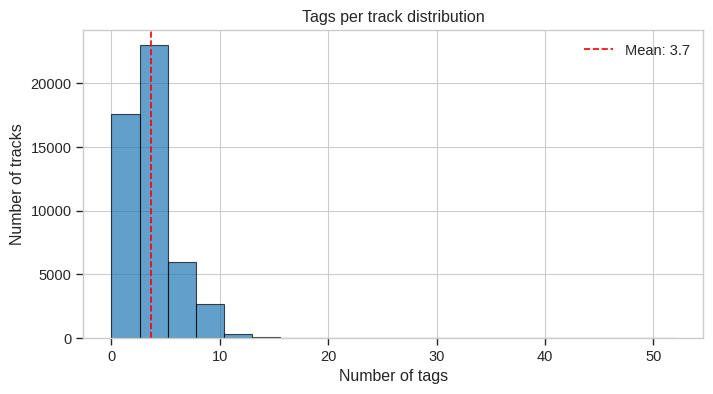

In [ ]:
print_tag_statistics(df)
plot_tag_distribution(df)

In [ ]:
model = SentenceTransformer('intfloat/multilingual-e5-base')
model_name = 'intfloat/multilingual-e5-base'

print(f"Liczba unikalnych tagów: {len(processed_tags)}")
print(f"Przykładowe tagi: {processed_tags[:10]}")

In [ ]:
e5_tag_embeddings = create_tag_embeddings(processed_tags, model, model_name)

In [ ]:
labse_model = SentenceTransformer('sentence-transformers/LaBSE')
labse_tag_embeddings = create_tag_embeddings(processed_tags, labse_model, 'LaBSE')

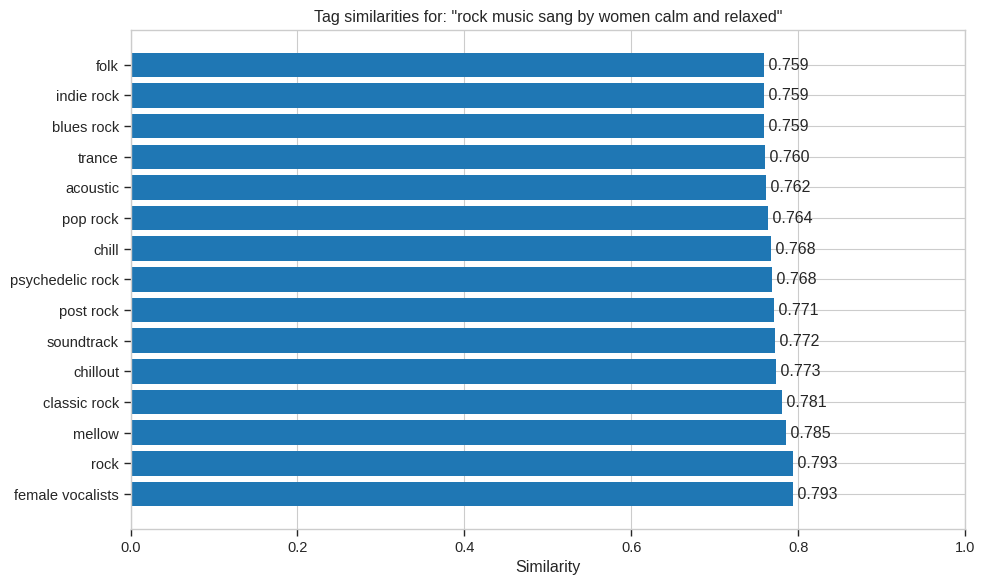

In [ ]:
visualize_tag_similarities(
    "rock music sang by women calm and relaxed",
    model, model_name, e5_tag_embeddings
)

Wizualiazcja embeddingów w przestrzeni dwuwymiarowej

In [ ]:
create_interactive_visualization(e5_tag_embeddings, 'multilingual e5 base')
create_interactive_visualization(labse_tag_embeddings, 'LaBSE')

Running t-SNE for interactive plot...


Running t-SNE for interactive plot...


In [ ]:
results = compare_all_models(processed_tags)


MODEL: E5-multilingual-base
Loading model...
  Load time: 5.56s
  Embedding dim: 768

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.922 (6 tags)
  electronic     : 0.885 (6 tags)
  metal          : 0.944 (6 tags)
  jazz_soul      : 0.900 (4 tags)
  calm_mood      : 0.881 (5 tags)
  aggressive     : 0.900 (3 tags)
  decades        : 0.936 (5 tags)

Overall semantic similarity: 0.910

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.144
   8 clusters: 0.147
  10 clusters: 0.152
  12 clusters: 0.154

  Main genres separation: 71.43% in different clusters
  Average silhouette score: 0.149

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.896 (should be high)
  Average INTER-category similarity: 0.878 (should be low)
  Separation (intra - inter): 0.018 (higher is better)

Test 4a: Polish Queries

Testing Polish → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaksująca muzyka' → ['psychedelic rock', 'soundtrack', 'melodic death metal', 'symphonic metal', 'chillout'] (40% accurate)
  'smutna muzyka' → ['melodic death metal', 'soundtrack', 'psychedelic rock', 'doom metal', 'symphonic metal'] (50% accurate)
  'wesoła muzyka' → ['soundtrack', 'symphonic metal', 'melodic death metal', 'female vocalists', 'classic rock'] (0% accurate)
  'romantyczne piosenki' → ['soundtrack', 'classic rock', 'singer songwriter', 'love', 'symphonic metal'] (50% accurate)
  'rock progresywny' → ['progressive rock', 'progressive metal', 'psychedelic rock', 'post rock', 'classic rock'] (100% accurate)
  'energiczny rock' → ['psychedelic rock', 'rock', 'post rock', 'hard rock', 'classic rock'] (50% accurate)
  'metal ekstremalny' → ['doom metal', 'symphonic metal', 'heavy metal', 'metal', 'power metal'] (73% accurate)
  'muzyka elektroniczna' → ['electronic', 'symphonic metal', 'melodic death metal', 'electro', 'soundtrack'] (36% accurate)
  'hip hop' → ['hip hop

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['soundtrack', 'downtempo', 'psychedelic rock', 'chillout', 'melodic death metal'] (60% accurate)
  'sad music' → ['soundtrack', 'melodic death metal', 'downtempo', 'doom metal', 'dark ambient'] (50% accurate)
  'happy music' → ['soundtrack', 'funk', 'symphonic metal', 'melodic death metal', 'psychedelic rock'] (67% accurate)
  'romantic songs' → ['soundtrack', 'classic rock', 'love', 'instrumental', 'singer songwriter'] (50% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'post rock', 'hard rock', 'classic rock'] (100% accurate)
  'energetic rock' → ['psychedelic rock', 'rock', 'post rock', 'classic rock', 'hard rock'] (50% accurate)
  'extreme metal' → ['heavy metal', 'doom metal', 'power metal', 'symphonic metal', 'melodic death metal'] (82% accurate)
  'electronic music' → ['electronic', 'electro', 'soundtrack', 'symphonic metal', 'techno'] (36% accurate)
  'hip hop' → ['hip hop', 'trip hop', 'rap', 'soundtrack', 'pop'] (67% accurate)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

  Load time: 14.78s
  Embedding dim: 384

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.912 (6 tags)
  electronic     : 0.857 (6 tags)
  metal          : 0.927 (6 tags)
  jazz_soul      : 0.875 (4 tags)
  calm_mood      : 0.861 (5 tags)
  aggressive     : 0.885 (3 tags)
  decades        : 0.892 (5 tags)

Overall semantic similarity: 0.887

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.080
   8 clusters: 0.122
  10 clusters: 0.119
  12 clusters: 0.110

  Main genres separation: 71.43% in different clusters
  Average silhouette score: 0.107

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.882 (should be high)
  Average INTER-category similarity: 0.863 (should be low)
  Separation (intra - inter): 0.020 (higher is better)

Test 4a: Polish Queries

Testing Polish → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaksująca muzyka' → ['soundtrack', 'psychedelic rock', 'reggae', 'instrumental', 'melodic death metal'] (0% accurate)
  'smutna muzyka' → ['melodic death metal', 'soundtrack', 'death metal', 'symphonic metal', 'thrash metal'] (50% accurate)
  'wesoła muzyka' → ['soul', 'soundtrack', 'alternative rock', 'psychedelic rock', 'melodic death metal'] (0% accurate)
  'romantyczne piosenki' → ['love', 'soundtrack', 'piano', 'pop rock', 'psychedelic rock'] (50% accurate)
  'rock progresywny' → ['progressive rock', 'progressive metal', 'rock', 'alternative rock', 'psychedelic rock'] (100% accurate)
  'energiczny rock' → ['rock', 'psychedelic rock', 'progressive rock', 'alternative rock', 'hard rock'] (100% accurate)
  'metal ekstremalny' → ['metal', 'thrash metal', 'power metal', 'heavy metal', 'doom metal'] (64% accurate)
  'muzyka elektroniczna' → ['electronic', 'electro', 'soundtrack', 'techno', 'melodic death metal'] (27% accurate)
  'hip hop' → ['hip hop', 'rap', 'trip hop', 'indie pop

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['soundtrack', 'reggae', 'psychedelic rock', 'alternative rock', 'instrumental'] (0% accurate)
  'sad music' → ['melodic death metal', 'death metal', 'soundtrack', 'indie pop', 'jazz'] (50% accurate)
  'happy music' → ['soundtrack', 'indie pop', 'psychedelic rock', 'melodic death metal', 'synthpop'] (0% accurate)
  'romantic songs' → ['soundtrack', 'love', 'instrumental', 'singer songwriter', 'pop rock'] (50% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'rock', 'psychedelic rock', 'classic rock'] (100% accurate)
  'energetic rock' → ['rock', 'psychedelic rock', 'hard rock', 'progressive rock', 'classic rock'] (75% accurate)
  'extreme metal' → ['heavy metal', 'metal', 'doom metal', 'power metal', 'thrash metal'] (64% accurate)
  'electronic music' → ['electronic', 'electro', 'soundtrack', 'techno', 'experimental'] (36% accurate)
  'hip hop' → ['hip hop', 'rap', 'trip hop', 'indie pop', 'j pop'] (67% accurate)
  'classical music' → ['cl

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaksująca muzyka' → ['psychedelic', 'soundtrack', 'symphonic metal', 'synthpop', 'classic rock'] (40% accurate)
  'smutna muzyka' → ['melodic death metal', 'singer songwriter', 'black metal', 'death metal', 'soundtrack'] (50% accurate)
  'wesoła muzyka' → ['melodic death metal', 'synthpop', 'symphonic metal', 'psychedelic', 'soundtrack'] (0% accurate)
  'romantyczne piosenki' → ['singer songwriter', 'male vocalists', 'pop rock', 'female vocalists', 'classic rock'] (50% accurate)
  'rock progresywny' → ['progressive rock', 'classic rock', 'pop rock', 'hard rock', 'post rock'] (100% accurate)
  'energiczny rock' → ['hard rock', 'classic rock', 'progressive rock', 'punk rock', 'pop rock'] (100% accurate)
  'metal ekstremalny' → ['heavy metal', 'thrash metal', 'doom metal', 'metal', 'power metal'] (73% accurate)
  'muzyka elektroniczna' → ['electronic', 'electro', 'metal', 'soundtrack', 'metalcore'] (36% accurate)
  'hip hop' → ['hip hop', 'trip hop', 'synthpop', 'indie pop', 'pop'] (

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['soundtrack', 'psychedelic', 'synthpop', 'symphonic metal', 'psychedelic rock'] (20% accurate)
  'sad music' → ['singer songwriter', 'melodic death metal', 'synthpop', 'soundtrack', 'black metal'] (0% accurate)
  'happy music' → ['synthpop', 'singer songwriter', 'melodic death metal', 'soundtrack', 'pop rock'] (0% accurate)
  'romantic songs' → ['singer songwriter', 'male vocalists', 'pop rock', 'classic rock', 'female vocalists'] (50% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'post rock', 'hard rock', 'pop rock'] (100% accurate)
  'energetic rock' → ['hard rock', 'progressive rock', 'psychedelic rock', 'alternative rock', 'rock'] (100% accurate)
  'extreme metal' → ['heavy metal', 'thrash metal', 'doom metal', 'metal', 'metalcore'] (73% accurate)
  'electronic music' → ['electronic', 'electro', 'synthpop', 'acoustic', 'metal'] (36% accurate)
  'hip hop' → ['hip hop', 'trip hop', 'synthpop', 'indie pop', 'pop'] (67% accurate)
  'cl

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 11.64s
  Embedding dim: 384

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.706 (6 tags)
  electronic     : 0.412 (6 tags)
  metal          : 0.740 (6 tags)
  jazz_soul      : 0.444 (4 tags)
  calm_mood      : 0.397 (5 tags)
  aggressive     : 0.418 (3 tags)
  decades        : 0.690 (5 tags)

Overall semantic similarity: 0.544

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.142
   8 clusters: 0.161
  10 clusters: 0.158
  12 clusters: 0.137

  Main genres separation: 71.43% in different clusters
  Average silhouette score: 0.149

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.475 (should be high)
  Average INTER-category similarity: 0.349 (should be low)
  Separation (intra - inter): 0.125 (higher is better)

Test 4a: Polish Queries

Testing Polish → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaksująca muzyka' → ['soundtrack', 'instrumental', 'acoustic', 'melodic death metal', 'reggae'] (0% accurate)
  'smutna muzyka' → ['melodic death metal', 'soundtrack', 'acoustic', 'classic rock', 'reggae'] (0% accurate)
  'wesoła muzyka' → ['instrumental', 'soundtrack', 'acoustic', 'reggae', 'melodic death metal'] (0% accurate)
  'romantyczne piosenki' → ['singer songwriter', 'indie rock', 'psychedelic rock', 'soundtrack', 'classic rock'] (50% accurate)
  'rock progresywny' → ['progressive rock', 'alternative rock', 'classic rock', 'rock', 'post rock'] (50% accurate)
  'energiczny rock' → ['rock', 'alternative rock', 'hard rock', 'classic rock', 'post rock'] (75% accurate)
  'metal ekstremalny' → ['metal', 'heavy metal', 'nu metal', 'progressive metal', 'black metal'] (64% accurate)
  'muzyka elektroniczna' → ['instrumental', 'acoustic', 'techno', 'soundtrack', 'indie rock'] (18% accurate)
  'hip hop' → ['hip hop', 'rap', 'punk rock', 'punk', 'post punk'] (67% accurate)
  'muzyka 

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['soundtrack', 'melodic death metal', 'instrumental', 'acoustic', 'alternative rock'] (0% accurate)
  'sad music' → ['melodic death metal', 'soundtrack', 'acoustic', 'classic rock', 'reggae'] (0% accurate)
  'happy music' → ['soundtrack', 'reggae', 'pop rock', 'indie rock', 'instrumental'] (0% accurate)
  'romantic songs' → ['singer songwriter', 'love', 'indie rock', 'psychedelic rock', 'soundtrack'] (50% accurate)
  'progressive rock' → ['progressive rock', 'alternative rock', 'rock', 'classic rock', 'pop rock'] (50% accurate)
  'energetic rock' → ['rock', 'hard rock', 'alternative rock', 'classic rock', 'post rock'] (75% accurate)
  'extreme metal' → ['heavy metal', 'metal', 'nu metal', 'progressive metal', 'power metal'] (64% accurate)
  'electronic music' → ['instrumental', 'techno', 'acoustic', 'electronic', 'soundtrack'] (18% accurate)
  'hip hop' → ['hip hop', 'rap', 'punk rock', 'punk', 'post punk'] (67% accurate)
  'classical music' → ['classical', 'sympho

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 22.32s
  Embedding dim: 768

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.753 (6 tags)
  electronic     : 0.392 (6 tags)
  metal          : 0.757 (6 tags)
  jazz_soul      : 0.441 (4 tags)
  calm_mood      : 0.430 (5 tags)
  aggressive     : 0.463 (3 tags)
  decades        : 0.636 (5 tags)

Overall semantic similarity: 0.553

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.095
   8 clusters: 0.118
  10 clusters: 0.071
  12 clusters: 0.071

  Main genres separation: 57.14% in different clusters
  Average silhouette score: 0.089

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.516 (should be high)
  Average INTER-category similarity: 0.344 (should be low)
  Separation (intra - inter): 0.172 (higher is better)

Test 4a: Polish Queries

Testing Polish → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaksująca muzyka' → ['downtempo', 'soundtrack', 'acoustic', 'jazz', 'mellow'] (40% accurate)
  'smutna muzyka' → ['melodic death metal', 'soundtrack', 'downtempo', 'blues', 'blues rock'] (0% accurate)
  'wesoła muzyka' → ['soundtrack', 'jazz', 'downtempo', 'instrumental', 'piano'] (0% accurate)
  'romantyczne piosenki' → ['love', 'singer songwriter', 'downtempo', 'beautiful', 'soundtrack'] (100% accurate)
  'rock progresywny' → ['progressive rock', 'rock', 'alternative rock', 'classic rock', 'hard rock'] (100% accurate)
  'energiczny rock' → ['rock', 'hard rock', 'progressive rock', 'alternative rock', 'classic rock'] (100% accurate)
  'metal ekstremalny' → ['metal', 'heavy metal', 'power metal', 'doom metal', 'metalcore'] (64% accurate)
  'muzyka elektroniczna' → ['techno', 'synthpop', 'electronic', 'soundtrack', 'instrumental'] (27% accurate)
  'hip hop' → ['hip hop', 'rap', 'synthpop', 'reggae', 'funk'] (67% accurate)
  'muzyka klasyczna' → ['classical', 'symphonic metal', 'ins

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['soundtrack', 'downtempo', 'jazz', 'acoustic', 'mellow'] (40% accurate)
  'sad music' → ['melodic death metal', 'soundtrack', 'downtempo', 'blues', 'blues rock'] (0% accurate)
  'happy music' → ['soundtrack', 'jazz', 'downtempo', 'reggae', 'pop rock'] (33% accurate)
  'romantic songs' → ['singer songwriter', 'love', 'soundtrack', 'downtempo', 'pop rock'] (100% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'alternative rock', 'pop rock', 'indie rock'] (100% accurate)
  'energetic rock' → ['rock', 'hard rock', 'progressive rock', 'classic rock', 'post rock'] (75% accurate)
  'extreme metal' → ['heavy metal', 'metal', 'metalcore', 'doom metal', 'thrash metal'] (73% accurate)
  'electronic music' → ['techno', 'synthpop', 'electronic', 'soundtrack', 'instrumental'] (27% accurate)
  'hip hop' → ['hip hop', 'rap', 'synthpop', 'reggae', 'funk'] (67% accurate)
  'classical music' → ['classical', 'symphonic metal', 'instrumental', 'piano', 'soun

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 6.70s
  Embedding dim: 384

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.664 (6 tags)
  electronic     : 0.366 (6 tags)
  metal          : 0.690 (6 tags)
  jazz_soul      : 0.415 (4 tags)
  calm_mood      : 0.240 (5 tags)
  aggressive     : 0.356 (3 tags)
  decades        : 0.574 (5 tags)

Overall semantic similarity: 0.472

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.119
   8 clusters: 0.130
  10 clusters: 0.154
  12 clusters: 0.142

  Main genres separation: 57.14% in different clusters
  Average silhouette score: 0.136

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.458 (should be high)
  Average INTER-category similarity: 0.346 (should be low)
  Separation (intra - inter): 0.112 (higher is better)

Test 4a: Polish Queries - SKIPPED (English-only model)

Test 4b: English Queries

Testing English → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['piano', 'trance', 'soundtrack', 'instrumental', 'dance'] (0% accurate)
  'sad music' → ['melodic death metal', 'soundtrack', 'death metal', 'classic rock', 'thrash metal'] (0% accurate)
  'happy music' → ['soundtrack', 'instrumental', 'love', 'funk', 'piano'] (33% accurate)
  'romantic songs' → ['oldies', 'soundtrack', 'singer songwriter', 'love', 'female vocalists'] (50% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'alternative rock', 'rock', 'punk rock'] (100% accurate)
  'energetic rock' → ['rock', 'alternative rock', 'post rock', 'psychedelic rock', 'hard rock'] (100% accurate)
  'extreme metal' → ['heavy metal', 'metal', 'death metal', 'black metal', 'progressive metal'] (64% accurate)
  'electronic music' → ['electronic', 'instrumental', 'techno', 'guitar', 'piano'] (27% accurate)
  'hip hop' → ['hip hop', 'rap', 'trip hop', 'dance', 'pop rock'] (67% accurate)
  'classical music' → ['classical', 'symphonic metal', 'piano', 'ins

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 11.55s
  Embedding dim: 768

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.658 (6 tags)
  electronic     : 0.304 (6 tags)
  metal          : 0.716 (6 tags)
  jazz_soul      : 0.383 (4 tags)
  calm_mood      : 0.318 (5 tags)
  aggressive     : 0.369 (3 tags)
  decades        : 0.684 (5 tags)

Overall semantic similarity: 0.490

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.085
   8 clusters: 0.133
  10 clusters: 0.143
  12 clusters: 0.146

  Main genres separation: 57.14% in different clusters
  Average silhouette score: 0.127

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.460 (should be high)
  Average INTER-category similarity: 0.358 (should be low)
  Separation (intra - inter): 0.102 (higher is better)

Test 4a: Polish Queries - SKIPPED (English-only model)

Test 4b: English Queries

Testing English → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['alternative rock', 'psychedelic rock', 'trance', 'melodic death metal', 'mellow'] (40% accurate)
  'sad music' → ['soundtrack', 'melodic death metal', 'trance', 'blues rock', 'dark ambient'] (50% accurate)
  'happy music' → ['soundtrack', 'instrumental', 'synthpop', 'trance', 'melodic death metal'] (0% accurate)
  'romantic songs' → ['indie pop', 'classical', 'synthpop', 'female vocalists', 'alternative rock'] (0% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'pop rock', 'post rock', 'indie rock'] (100% accurate)
  'energetic rock' → ['rock', 'hard rock', 'post rock', 'pop rock', 'power metal'] (100% accurate)
  'extreme metal' → ['metalcore', 'death metal', 'doom metal', 'thrash metal', 'heavy metal'] (64% accurate)
  'electronic music' → ['techno', 'synthpop', 'electronic', 'alternative rock', 'drum and bass'] (36% accurate)
  'hip hop' → ['hip hop', 'rap', 'pop rock', 'indie pop', 'britpop'] (67% accurate)
  'classical music' → ['c

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 9.17s
  Embedding dim: 384

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.643 (6 tags)
  electronic     : 0.329 (6 tags)
  metal          : 0.692 (6 tags)
  jazz_soul      : 0.421 (4 tags)
  calm_mood      : 0.301 (5 tags)
  aggressive     : 0.416 (3 tags)
  decades        : 0.718 (5 tags)

Overall semantic similarity: 0.503

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.127
   8 clusters: 0.166
  10 clusters: 0.141
  12 clusters: 0.159

  Main genres separation: 71.43% in different clusters
  Average silhouette score: 0.148

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.420 (should be high)
  Average INTER-category similarity: 0.298 (should be low)
  Separation (intra - inter): 0.123 (higher is better)

Test 4a: Polish Queries - SKIPPED (English-only model)

Test 4b: English Queries

Testing English → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['acoustic', 'instrumental', 'melodic death metal', 'psychedelic rock', 'indie rock'] (0% accurate)
  'sad music' → ['progressive rock', 'melodic death metal', 'blues rock', 'classic rock', 'funk'] (0% accurate)
  'happy music' → ['pop rock', 'indie rock', 'progressive rock', 'classic rock', 'instrumental'] (0% accurate)
  'romantic songs' → ['love', 'indie rock', 'pop rock', 'classic rock', 'singer songwriter'] (50% accurate)
  'progressive rock' → ['progressive rock', 'alternative rock', 'classic rock', 'pop rock', 'indie rock'] (50% accurate)
  'energetic rock' → ['rock', 'hard rock', 'alternative rock', 'classic rock', 'post rock'] (75% accurate)
  'extreme metal' → ['heavy metal', 'metal', 'black metal', 'power metal', 'nu metal'] (64% accurate)
  'electronic music' → ['electronic', 'techno', 'instrumental', 'symphonic metal', 'acoustic'] (27% accurate)
  'hip hop' → ['hip hop', 'rap', 'punk rock', 'punk', 'post punk'] (67% accurate)
  'classical music' → ['cl

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 13.59s
  Embedding dim: 768

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.700 (6 tags)
  electronic     : 0.364 (6 tags)
  metal          : 0.643 (6 tags)
  jazz_soul      : 0.277 (4 tags)
  calm_mood      : 0.309 (5 tags)
  aggressive     : 0.395 (3 tags)
  decades        : 0.665 (5 tags)

Overall semantic similarity: 0.479

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.095
   8 clusters: 0.115
  10 clusters: 0.138
  12 clusters: 0.122

  Main genres separation: 85.71% in different clusters
  Average silhouette score: 0.118

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.439 (should be high)
  Average INTER-category similarity: 0.329 (should be low)
  Separation (intra - inter): 0.110 (higher is better)

Test 4a: Polish Queries - SKIPPED (English-only model)

Test 4b: English Queries

Testing English → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['instrumental', 'acoustic', 'thrash metal', 'alternative rock', 'drum and bass'] (0% accurate)
  'sad music' → ['acoustic', 'melodic death metal', 'symphonic metal', 'gothic metal', 'doom metal'] (0% accurate)
  'happy music' → ['acoustic', 'love', 'melodic death metal', 'soundtrack', 'piano'] (33% accurate)
  'romantic songs' → ['melodic death metal', 'symphonic metal', '00s', 'psychedelic', 'psychedelic rock'] (0% accurate)
  'progressive rock' → ['progressive rock', 'alternative rock', 'classic rock', 'pop rock', 'progressive metal'] (100% accurate)
  'energetic rock' → ['hard rock', 'alternative rock', 'indie rock', 'classic rock', 'psychedelic rock'] (75% accurate)
  'extreme metal' → ['heavy metal', 'hardcore', 'hard rock', 'death metal', 'progressive metal'] (55% accurate)
  'electronic music' → ['electronic', 'acoustic', 'electro', 'melodic death metal', 'instrumental'] (36% accurate)
  'hip hop' → ['hip hop', 'trip hop', 'pop', 'j pop', 'pop rock'] (67% a

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 24.76s
  Embedding dim: 768

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.552 (6 tags)
  electronic     : 0.217 (6 tags)
  metal          : 0.642 (6 tags)
  jazz_soul      : 0.191 (4 tags)
  calm_mood      : 0.210 (5 tags)
  aggressive     : 0.373 (3 tags)
  decades        : 0.395 (5 tags)

Overall semantic similarity: 0.368

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.101
   8 clusters: 0.109
  10 clusters: 0.111
  12 clusters: 0.113

  Main genres separation: 57.14% in different clusters
  Average silhouette score: 0.108

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.345 (should be high)
  Average INTER-category similarity: 0.224 (should be low)
  Separation (intra - inter): 0.120 (higher is better)

Test 4a: Polish Queries - SKIPPED (English-only model)

Test 4b: English Queries

Testing English → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['beautiful', 'acoustic', 'instrumental', 'soundtrack', 'chill'] (40% accurate)
  'sad music' → ['dark ambient', 'noise', 'instrumental', 'soundtrack', 'classic rock'] (50% accurate)
  'happy music' → ['beautiful', 'love', 'synthpop', 'soundtrack', 'new wave'] (67% accurate)
  'romantic songs' → ['love', 'singer songwriter', 'beautiful', 'synthpop', 'pop rock'] (100% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'alternative rock', 'post rock', 'classic rock'] (100% accurate)
  'energetic rock' → ['progressive rock', 'alternative rock', 'hard rock', 'punk rock', 'electronic'] (100% accurate)
  'extreme metal' → ['heavy metal', 'thrash metal', 'death metal', 'power metal', 'metal'] (73% accurate)
  'electronic music' → ['electronic', 'electro', 'techno', 'dark ambient', 'instrumental'] (45% accurate)
  'hip hop' → ['hip hop', 'trip hop', 'j pop', 'pop', 'pop rock'] (67% accurate)
  'classical music' → ['classical', 'classic rock', 'britp

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Load time: 12.88s
  Embedding dim: 768

Test 1: Semantic Similarity

Testing Semantic Similarity...
  rock_family    : 0.703 (6 tags)
  electronic     : 0.258 (6 tags)
  metal          : 0.712 (6 tags)
  jazz_soul      : 0.275 (4 tags)
  calm_mood      : 0.219 (5 tags)
  aggressive     : 0.370 (3 tags)
  decades        : 0.732 (5 tags)

Overall semantic similarity: 0.467

Test 2: Clustering Quality

Testing Clustering Quality...
   5 clusters: 0.083
   8 clusters: 0.121
  10 clusters: 0.151
  12 clusters: 0.152

  Main genres separation: 71.43% in different clusters
  Average silhouette score: 0.127

Test 3: Category Separation

Testing Inter vs Intra Category Similarity...
  Average INTRA-category similarity: 0.446 (should be high)
  Average INTER-category similarity: 0.346 (should be low)
  Separation (intra - inter): 0.100 (higher is better)

Test 4a: Polish Queries - SKIPPED (English-only model)

Test 4b: English Queries

Testing English → Tag mapping...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  'relaxing music' → ['progressive rock', 'punk rock', 'drum and bass', 'psychedelic rock', 'progressive metal'] (0% accurate)
  'sad music' → ['death metal', 'melodic death metal', 'doom metal', 'black metal', 'hard rock'] (0% accurate)
  'happy music' → ['hip hop', 'hard rock', 'classic rock', 'dance', 'synthpop'] (33% accurate)
  'romantic songs' → ['soundtrack', 'progressive rock', 'hard rock', 'classic rock', 'classical'] (0% accurate)
  'progressive rock' → ['progressive rock', 'progressive metal', 'punk rock', 'alternative rock', 'pop rock'] (100% accurate)
  'energetic rock' → ['rock', 'alternative rock', 'progressive rock', 'hard rock', 'indie rock'] (100% accurate)
  'extreme metal' → ['heavy metal', 'death metal', 'black metal', 'progressive metal', 'melodic death metal'] (64% accurate)
  'electronic music' → ['electronic', 'progressive metal', 'punk rock', 'instrumental', 'progressive rock'] (18% accurate)
  'hip hop' → ['hip hop', 'trip hop', 'indie pop', 'synthpop', 'rap'

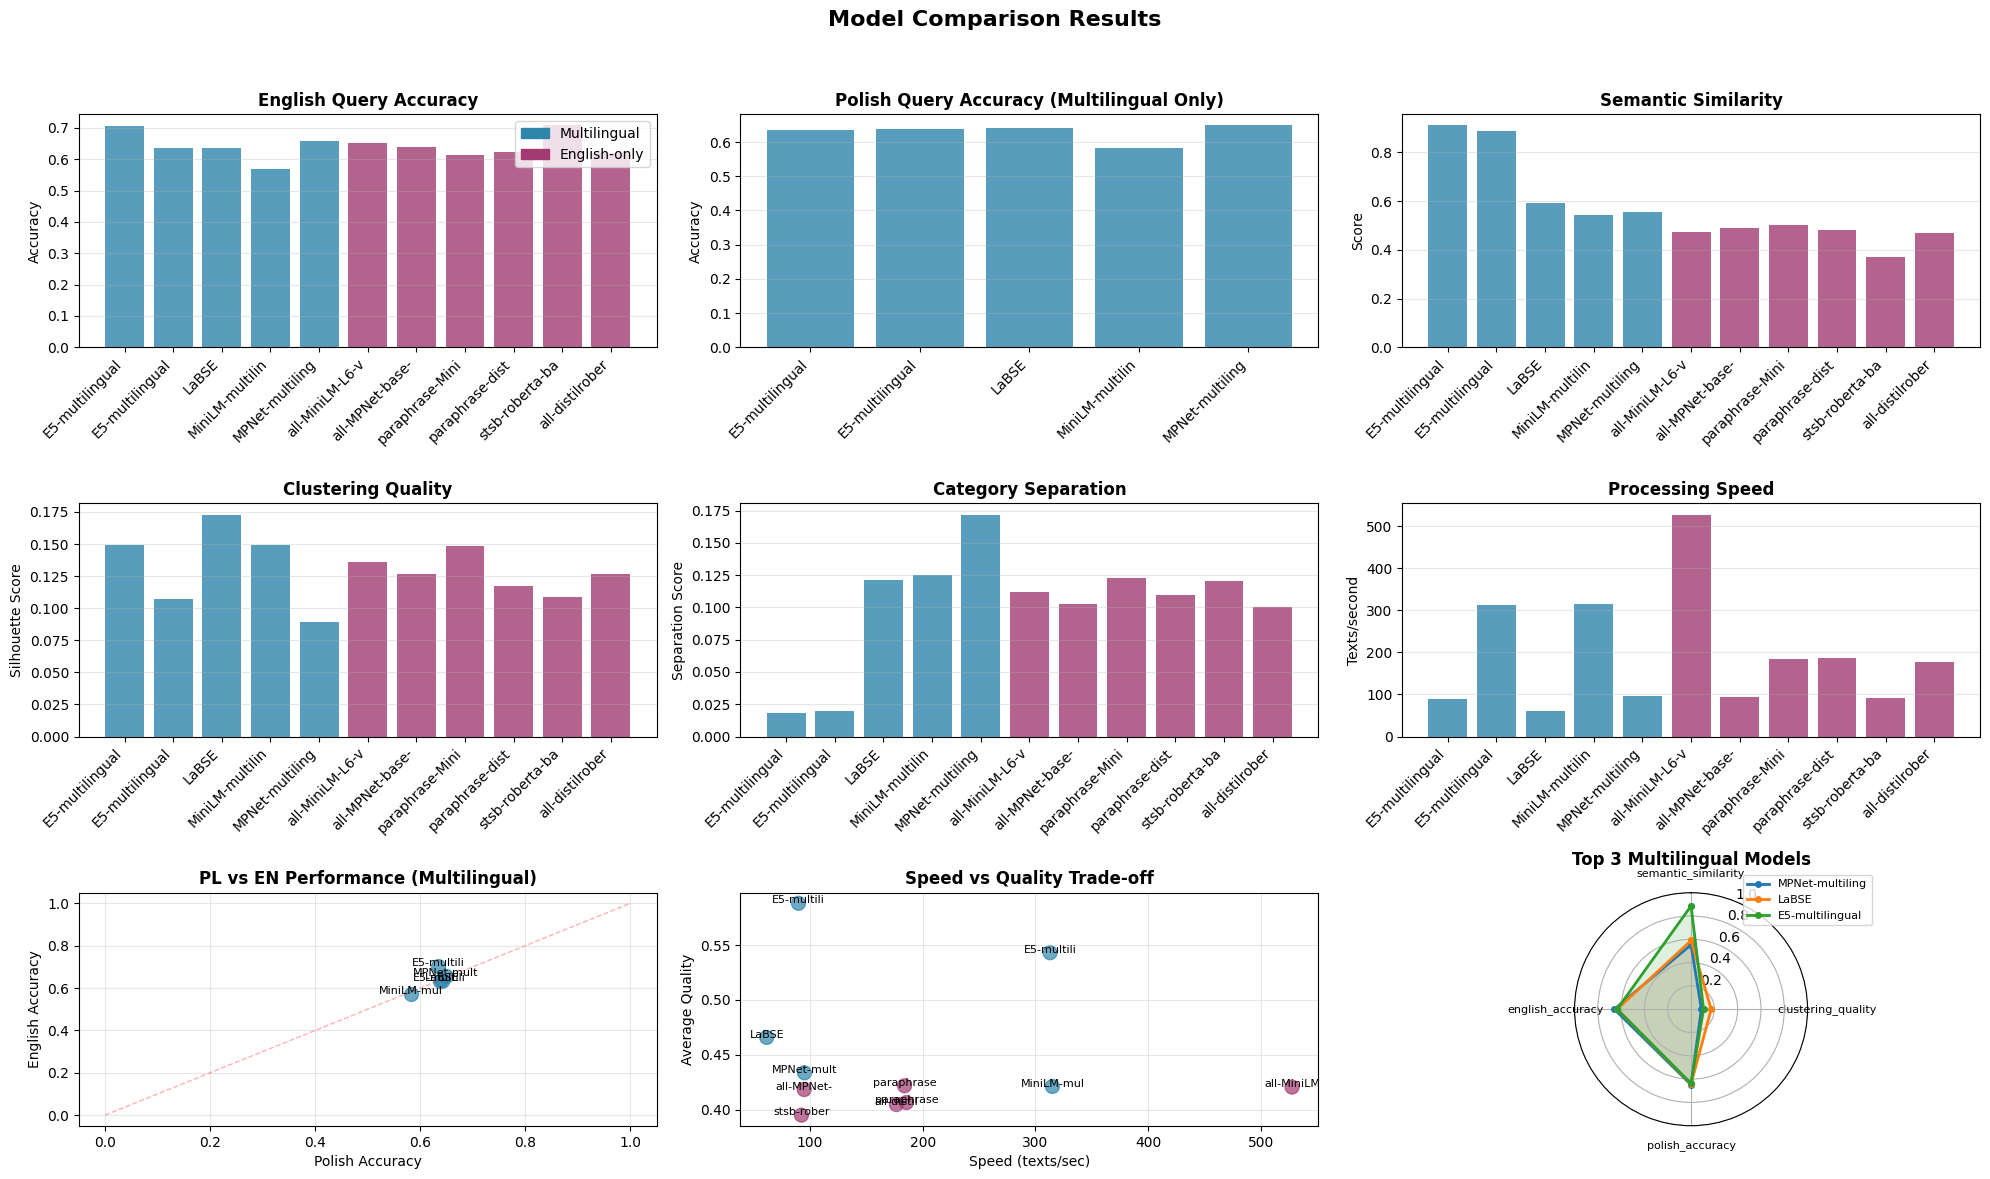


MULTILINGUAL MODELS RESULTS
                       polish_accuracy  english_accuracy  semantic_similarity  clustering_quality  category_separation    speed
MPNet-multilingual               0.649             0.659                0.553               0.089                0.172   95.256
LaBSE                            0.642             0.635                0.590               0.173                0.121   61.757
E5-multilingual-small            0.637             0.635                0.887               0.107                0.020  312.994
E5-multilingual-base             0.635             0.705                0.910               0.149                0.018   89.922
MiniLM-multilingual              0.582             0.570                0.544               0.149                0.125  315.029

ENGLISH-ONLY MODELS RESULTS
                                  english_accuracy  semantic_similarity  clustering_quality  category_separation    speed
stsb-roberta-base                            0.708  

In [ ]:
results_df = visualize_results(results)

**Wnioski**

Wybieramy E5-multilingual-base, ponieważ w testach multilingual wypadł najlepiej pod względem równowagi między dokładnością dla polskich i angielskich zapytań, semantyczną spójnością tagów i szybkością przetwarzania. Modele multilingual w ogóle nie odstają od modeli anglojęzycznych, a w wielu przypadkach nawet je przewyższają, więc są sensownym wyborem do naszego scenariusza. E5 jest też wystarczająco szybki, by obsługiwać zapytania w czasie rzeczywistym, a dodatkowy fine-tuning na naszych danych mógłby jeszcze poprawić dopasowanie tagów.

In [ ]:
category_results_pl = test_model_by_category(model, model_name, processed_tags, lang='pl')

In [ ]:
category_results_labse = test_model_by_category(labse_model, 'LaBSE', processed_tags, lang='pl')


ANALIZA KATEGORII - Model: LaBSE | Język: Polski


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


📊 NASTRÓJ I EMOCJE
------------------------------------------------------------
  ⚠️ 'relaksująca muzyka            ' F1: 0.40 | Trafione: 2/5
     ↳ Znalezione: ['chill', 'mellow']
     ↳ Pominięte: ['ambient', 'chillout', 'downtempo']
  ✅ 'smutna muzyka                 ' F1: 0.50 | Trafione: 1/2
  ❌ 'wesoła muzyka                 ' F1: 0.00 | Trafione: 0/3
     ↳ Znalezione: brak
     ↳ Pominięte: ['funk', 'pop', 'dance']
  ✅ 'romantyczne piosenki          ' F1: 0.50 | Trafione: 1/2
  ❌ 'mroczna i niepokojąca         ' F1: 0.20 | Trafione: 1/5
     ↳ Znalezione: ['dark ambient']
     ↳ Pominięte: ['doom metal', 'noise', 'gothic']
  ⚠️ 'nostalgiczna i melancholijna  ' F1: 0.40 | Trafione: 2/5
     ↳ Znalezione: ['emo', 'singer songwriter']
     ↳ Pominięte: ['folk', 'acoustic', 'indie']
  ⚠️ 'agresywna i brutalna          ' F1: 0.40 | Trafione: 2/5
     ↳ Znalezione: ['grindcore', 'hardcore']
     ↳ Pominięte: ['death metal', 'thrash metal', 'metalcore']
  ⚠️ 'eteryczna i przestrzenn

# Zapisz i odczyt wyników

In [ ]:
def save_results(results: Dict, results_df: pd.DataFrame,
                 prefix: str = "model_comparison") -> None:
    """
    Zapisuje wyniki porównania modeli do plików.

    Args:
        results: Słownik z surowymi wynikami
        results_df: DataFrame z przetworzonymi wynikami
        prefix: Prefiks nazw plików
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    csv_path = f"{prefix}_{timestamp}.csv"
    results_df.to_csv(csv_path)
    print(f"Zapisano CSV: {csv_path}")

    json_path = f"{prefix}_{timestamp}.json"

    def convert_to_serializable(obj):
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj

    serializable_results = {
        model: {k: convert_to_serializable(v) for k, v in data.items()}
        for model, data in results.items()
    }

    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(serializable_results, f, indent=2, ensure_ascii=False)
    print(f"Zapisano JSON: {json_path}")

    pickle_path = f"{prefix}_{timestamp}.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump({'results': results, 'results_df': results_df}, f)
    print(f"Zapisano Pickle: {pickle_path}")


def load_results(pickle_path: str) -> Tuple[Dict, pd.DataFrame]:
    """
    Wczytuje wyniki z pliku pickle.

    Args:
        pickle_path: Ścieżka do pliku .pkl

    Returns:
        Tuple (results dict, results DataFrame)
    """
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Wczytano wyniki z: {pickle_path}")
    return data['results'], data['results_df']


def save_category_analysis(category_results: Dict, model_name: str,
                           lang: str = 'pl') -> None:
    """
    Zapisuje wyniki analizy kategorii.

    Args:
        category_results: Wyniki z test_model_by_category
        model_name: Nazwa modelu
        lang: Język testów
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    simplified = {}
    for cat_key, cat_data in category_results.items():
        simplified[cat_key] = {
            'name': cat_data['name'],
            'avg_f1': float(cat_data['avg_f1']),
            'std_f1': float(cat_data['std_f1']),
            'min_f1': float(cat_data['min_f1']),
            'max_f1': float(cat_data['max_f1']),
            'needs_finetuning': bool(cat_data['needs_finetuning']),
            'queries': [
                {
                    'query': q['query'],
                    'f1': float(q['f1']),
                    'precision': float(q['precision']),
                    'recall': float(q['recall']),
                    'expected': q['expected'],
                    'found': q['found'],
                    'missed': q['missed']
                }
                for q in cat_data['queries']
            ]
        }

    filename = f"category_analysis_{model_name.replace('/', '_')}_{lang}_{timestamp}.json"

m    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(simplified, f, indent=2, ensure_ascii=False)

    print(f"Zapisano analizę kategorii: {filename}")

In [ ]:
# save_results(results, results_df)

# save_category_analysis(category_results_pl, 'E5-multilingual-base', lang='pl')
# save_category_analysis(category_results_labse, 'LaBSE', lang='pl')

Zapisano CSV: model_comparison_20260105_190747.csv
Zapisano JSON: model_comparison_20260105_190747.json
Zapisano Pickle: model_comparison_20260105_190747.pkl
Zapisano analizę kategorii: category_analysis_E5-multilingual-base_pl_20260105_190747.json
Zapisano analizę kategorii: category_analysis_LaBSE_pl_20260105_190747.json
